In [1]:
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.linalg import block_diag

module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
module_path = os.path.abspath(os.path.join('../../data'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from dynamics import Dynamics
from utils import get_form_initial_conditions
from centralized_newton import CentralizedNewton

In [2]:
# Position estimation error
def position_estimation_error(X_est, X_true):
    return np.linalg.norm(X_est[:3, :, :] - X_true[:3, :, :], axis=0).flatten(), np.linalg.norm(X_est[6:9, :, :] - X_true[6:9, :, :], axis=0).flatten(), np.linalg.norm(X_est[12:15, :, :] - X_true[12:15, :, :], axis=0).flatten(), np.linalg.norm(X_est[18:21, :, :] - X_true[18:21, :, :], axis=0).flatten()

In [3]:
# Simulation parameters
dt = 60.0  # Time step [s]
K = 395  # Duration [min]
M = 1  # Number of Monte-Carlo simulations
N = 4  # Number of satellites
formation = 1
n_x = 6 
n_p = 3  
n = N * n_x
o = 3 + 3 + 2 + 1 
H = 50 # Window size [min]
invalid_rmse = 1e20 # [m]
grad_norm_order_mag = True
grad_norm_tol = 1e-6
max_iterations = 20
dyn = Dynamics()

In [4]:
# Observation noise
r_chief_pos = 1e-1  # [m]
R_chief = np.diag(np.concatenate([r_chief_pos * np.ones(3)])) ** 2
r_deputy_pos = 1e0  # [m]
R_deputies = np.diag(np.concatenate([r_deputy_pos * np.ones(6)])) ** 2
R = block_diag(R_chief, R_deputies)

# Initial deviation noise
p_pos_initial = 1e2  # [m]
p_vel_initial = 1e-2  # [m / s]
P_0 = np.diag(np.concatenate([p_pos_initial * np.ones(3), p_vel_initial * np.ones(3)])) ** 2
P_0 = block_diag(P_0, P_0, P_0, P_0)

In [5]:
def plots(k, algorithm_class):
    iterations = np.arange(0, algorithm_class.iterations + 1)

    fig, axs = plt.subplots(1, 4, figsize=(24, 5))

    # Plot 1
    axs[0].semilogy(iterations, 1 / H * np.array(algorithm_class.cost_values), '.-')
    axs[0].set_xlabel(r'$n$')
    axs[0].set_ylabel(r'$\frac{1}{H}J(x_n)$')
    axs[0].set_title('Normalized Cost Function') 
    axs[0].grid()

    # Plot 2
    axs[1].semilogy(iterations, 1 / H * np.array(algorithm_class.gradient_norm_values), '.-')
    axs[1].set_xlabel(r'$n$')
    axs[1].set_ylabel(r'$\frac{1}{H}||\nabla J(x_n)||_2$')
    axs[1].set_title('Normalized Gradient Norm')
    axs[1].grid()
    
    # Plot 3 
    HJ_x_min_eigenvalues = [min(HJ_x_eigenvalues) for HJ_x_eigenvalues in algorithm_class.HJ_x_eigenvalues_history]
    axs[2].plot(iterations, HJ_x_min_eigenvalues, '.-', label=r'\frac{\|\mathbf{A}\|}{\|\mathbf{C}\|}')
    for i, (x, y) in enumerate(zip(iterations, HJ_x_min_eigenvalues)):
        if y > 0:
            color = 'green'
        elif y == 0:
            color = 'yellow'
        else:
            color = 'red'
        axs[2].plot(x, y, marker='o', color=color, markersize=6)
    axs[2].set_xlabel(r'$n$')
    axs[2].set_title(r'$\nabla^2 J(x_n)$ minimum eigenvalue')
    axs[2].grid()
    
    # Plot 4 
    # Hessian matrix maximum eigenvalue and Hessian matrix terms ratios (A - observations second-order partials, B - dynamics second-order partials, C - Gauss-Newton) over iterations
    axs[3].semilogy(iterations, np.array(algorithm_class.A_norm_history) / np.array(algorithm_class.C_norm_history), '.-', label=r'$\frac{\|\mathbf{A}\|}{\|\mathbf{C}\|}$')
    axs[3].semilogy(iterations, np.array(algorithm_class.B_norm_history) / np.array(algorithm_class.C_norm_history), '.-', label=r'$\frac{\|\mathbf{B}\|}{\|\mathbf{C}\|}$')
    axs[3].set_xlabel(r'$n$')
    axs[3].set_title('Hessian matrix terms Frobenius norm ratios')
    axs[3].legend()
    axs[3].grid()
    
    fig.suptitle(f'Solving MHE problem J(k) with k = {k}', fontsize=14)

    plt.tight_layout()
    plt.show()

In [6]:
# Seed for reproducibility
np.random.seed(42)

# Initial conditions for the state vector and true state vectors
X_initial = get_form_initial_conditions(formation)
with open(f"../../data/tudatpy_form{formation}.pkl", "rb") as file:
    X_true = pickle.load(file)[:, :, :K]

# Initial position estimation error
X_est = np.zeros_like(X_true)
X_est[:, :, 0] = X_initial + np.random.multivariate_normal(np.zeros(n), P_0).reshape((n, 1))
for k in range(K - 1):
    X_est[:, :, k + 1] = dyn.f(dt, X_est[:, :, k])
position_estimation_error_1_initial, position_estimation_error_2_initial, position_estimation_error_3_initial, position_estimation_error_4_initial = position_estimation_error(X_est, X_true)

# Algorithm class to use
centralized_newton = CentralizedNewton(H, K, o, R, grad_norm_order_mag, grad_norm_tol, max_iterations)

# Observations
Y = np.zeros((o, 1, K))
for k in range(K):
    Y[:, :, k] = centralized_newton.h(X_true[:, :, k]) + np.random.multivariate_normal(np.zeros(o), R).reshape((o, 1))

Windows:   0%|          | 0/346 [00:00<?, ?it/s]

[Centralized Newton] Before applying the algorithm
Cost function: 2822004289.414573
Gradient norm: 24597705336.651653
Global estimation error: 429.5049051950654
2.1564139173631047 0.001953984112692318 6.594477250268854e-05
Initial conditions estimation errors: 272.4697073631671 m, 173.20827048056321 m, 227.77973283351287 m, 168.3746081658613 m
Position estimation errors: 2165.153517154223 m, 2840.6208130359214 m, 890.8408423187244 m, 596.8916279880967 m

[Centralized Newton] Iteration 1
Cost function: 1943190.8492123734 (-99.93%)
Gradient norm: 20211478.558407743 (-99.92%)
Global estimation error: 420.69610329924603 (-2.05%)
0.35556709269772424 9.396230498498692e-05 4.835918805300855e-07
Initial conditions estimation errors: 57.91954040703106 m, 170.23066275433382 m, 292.30373494792553 m, 243.3319560093065 m
Position estimation errors: 37.83646886616287 m, 293.5464238952716 m, 472.092666778025 m, 297.33205528230127 m

[Centralized Newton] Iteration 2
Cost function: 1395868.2176619673 (

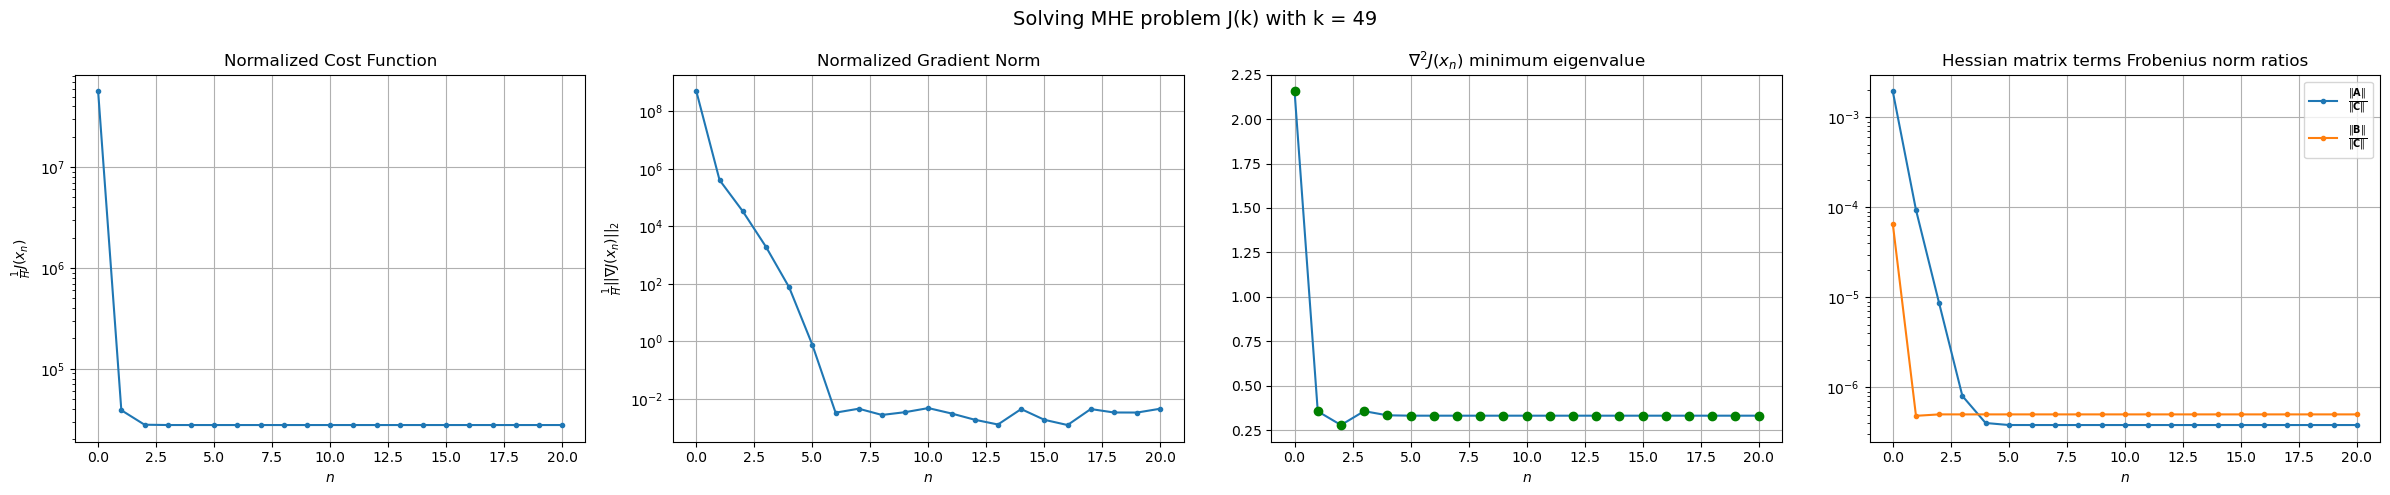

Windows:   0%|          | 1/346 [04:00<23:02:16, 240.40s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 1303768.1116824397
Gradient norm: 18150077.30261568
Global estimation error: 101.05676190118714
0.21609113133028696 9.741208206922185e-07 4.974441976475132e-07
Initial conditions estimation errors: 51.22866099433601 m, 50.34525310461578 m, 50.53569765868274 m, 49.9950784851457 m
Position estimation errors: 40.28769203251383 m, 40.83968866094759 m, 41.3376879981343 m, 41.59378614654434 m

[Centralized Newton] Iteration 1
Cost function: 1281073.1871426878 (-1.74%)
Gradient norm: 196.55837964112666 (-100.00%)
Global estimation error: 111.23768776944645 (10.07%)
0.2163779332941545 7.372863445268271e-07 4.871309051196645e-07
Initial conditions estimation errors: 56.058522455926784 m, 55.38277803086065 m, 55.66651577617726 m, 55.36390855371868 m
Position estimation errors: 36.378404794704075 m, 36.68093784374768 m, 37.00414796366205 m, 36.97703269267381 m

[Centralized Newton] Iteration 2
Cost function: 1281073.1871517138 (0.0

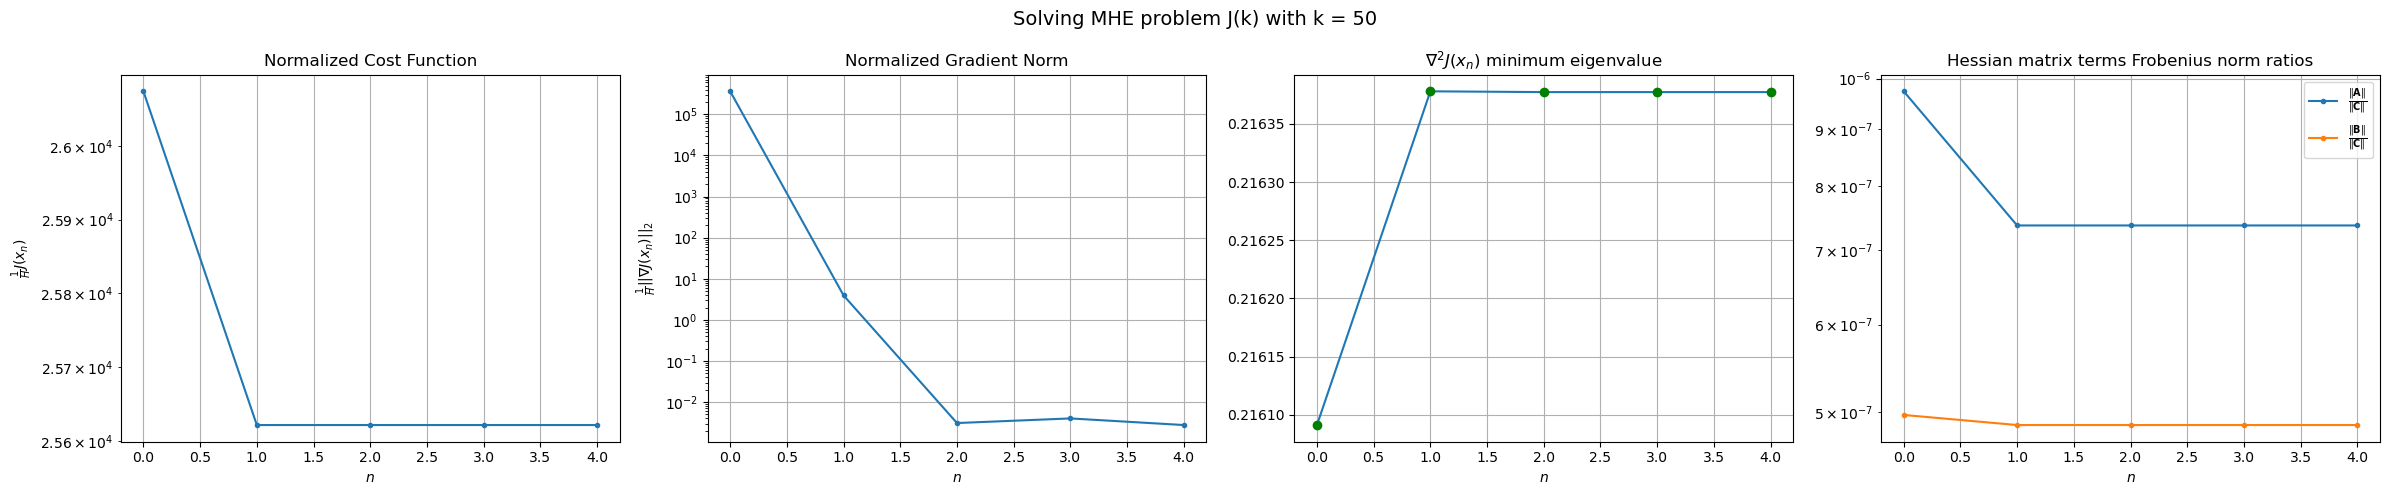

Windows:   1%|          | 2/346 [04:57<12:40:49, 132.70s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 1200889.8918356788
Gradient norm: 17315258.31810536
Global estimation error: 99.28188981704811
0.16403279995444744 1.001287590778953e-06 4.812149891053608e-07
Initial conditions estimation errors: 50.100099047101764 m, 49.58281291579114 m, 49.642985796172965 m, 49.233310560209404 m
Position estimation errors: 39.12370027570681 m, 39.25808969971012 m, 39.874237025734374 m, 39.81903341312164 m

[Centralized Newton] Iteration 1
Cost function: 1179927.1493376833 (-1.75%)
Gradient norm: 176.16192534856316 (-100.00%)
Global estimation error: 109.15808403322869 (9.95%)
0.16481024511495898 1.0341507223964806e-06 4.7323276349581733e-07
Initial conditions estimation errors: 54.60531443429322 m, 54.22758260013166 m, 54.89731109842679 m, 54.58318606000064 m
Position estimation errors: 35.2824889011932 m, 35.19436903116494 m, 35.037059013446985 m, 35.00058893435477 m

[Centralized Newton] Iteration 2
Cost function: 1179927.1493125958

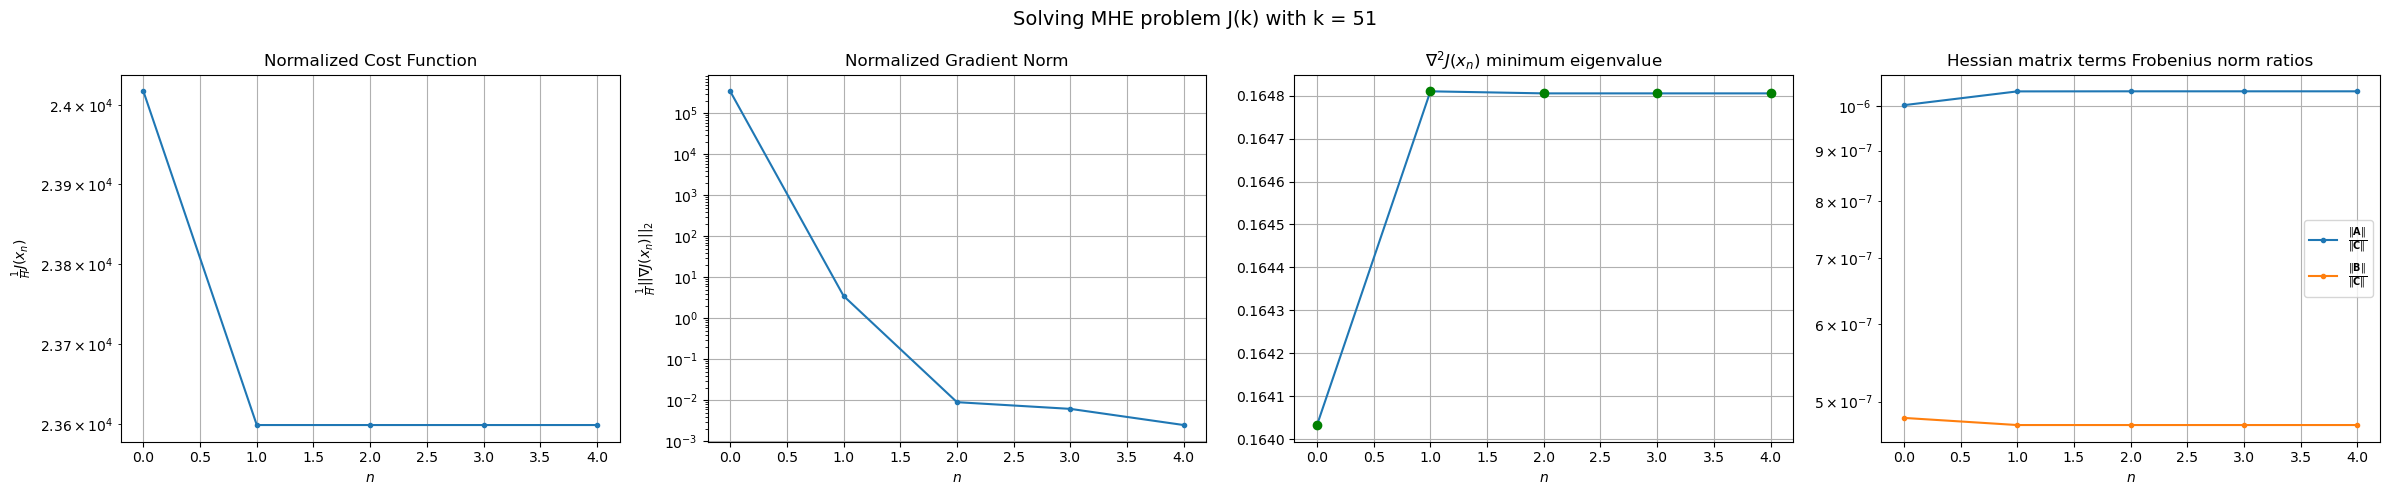

Windows:   1%|          | 3/346 [05:55<9:21:58, 98.30s/it]  

[Centralized Newton] Before applying the algorithm
Cost function: 1102409.3989823516
Gradient norm: 16311219.516049152
Global estimation error: 97.58750898098018
0.12229563218837959 1.1811150014110538e-06 4.65016279305048e-07
Initial conditions estimation errors: 48.76021556003601 m, 48.53888323606994 m, 49.06489999883357 m, 48.808943654626326 m
Position estimation errors: 37.916127657896624 m, 37.65430329603547 m, 37.69075678952428 m, 37.587666448699544 m

[Centralized Newton] Iteration 1
Cost function: 1083016.9110010224 (-1.76%)
Gradient norm: 201.03179563968905 (-100.00%)
Global estimation error: 103.65916007390818 (6.22%)
0.12302226168229163 1.024546955612362e-06 4.5864032559473746e-07
Initial conditions estimation errors: 52.987399840896856 m, 51.57584377834058 m, 52.39610635869172 m, 50.31969621513695 m
Position estimation errors: 34.15080374614677 m, 35.143016336460015 m, 35.35139136054214 m, 35.18373625073418 m

[Centralized Newton] Iteration 2
Cost function: 1083016.910815617

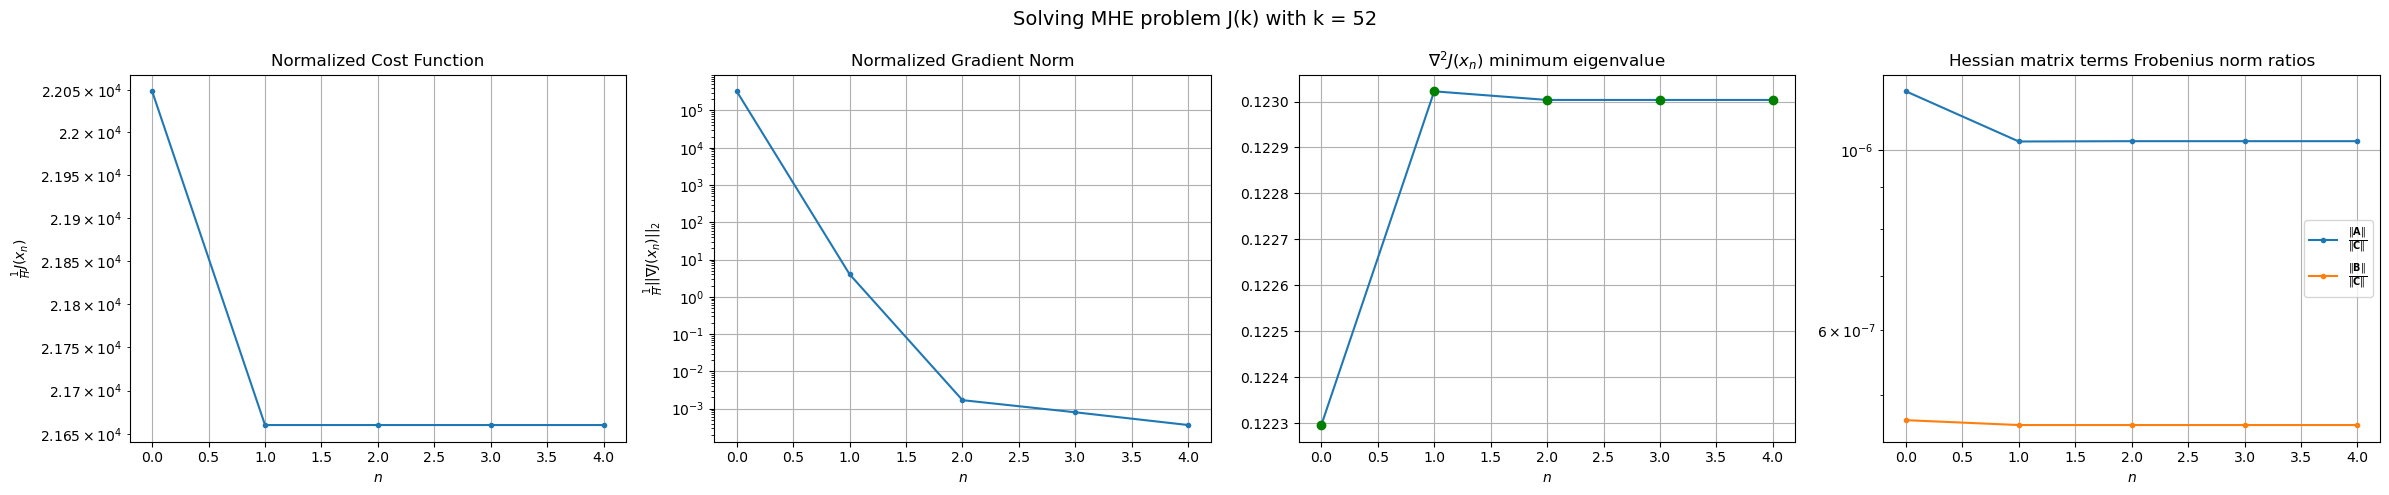

Windows:   1%|          | 4/346 [06:52<7:47:55, 82.09s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 1009945.7927192204
Gradient norm: 15148408.892790614
Global estimation error: 92.39988985088578
0.08671148380219584 2.8450488301807824e-06 4.493211299173776e-07
Initial conditions estimation errors: 47.26462141170926 m, 46.02478322459206 m, 46.54188990296459 m, 44.93677141360512 m
Position estimation errors: 36.69150741006825 m, 37.4596169896222 m, 37.88533265638992 m, 37.66564430599171 m

[Centralized Newton] Iteration 1
Cost function: 992295.9339648806 (-1.75%)
Gradient norm: 146.91564423335586 (-100.00%)
Global estimation error: 99.61613385803794 (7.81%)
0.08626013015537697 2.2520587249344677e-06 4.43609897145595e-07
Initial conditions estimation errors: 51.22262822039558 m, 50.25235802972358 m, 49.65139241708852 m, 48.05205902756707 m
Position estimation errors: 33.05304055020672 m, 33.566050991947414 m, 34.646089191802076 m, 34.72402868248304 m

[Centralized Newton] Iteration 2
Cost function: 992295.9339672349 (0.00

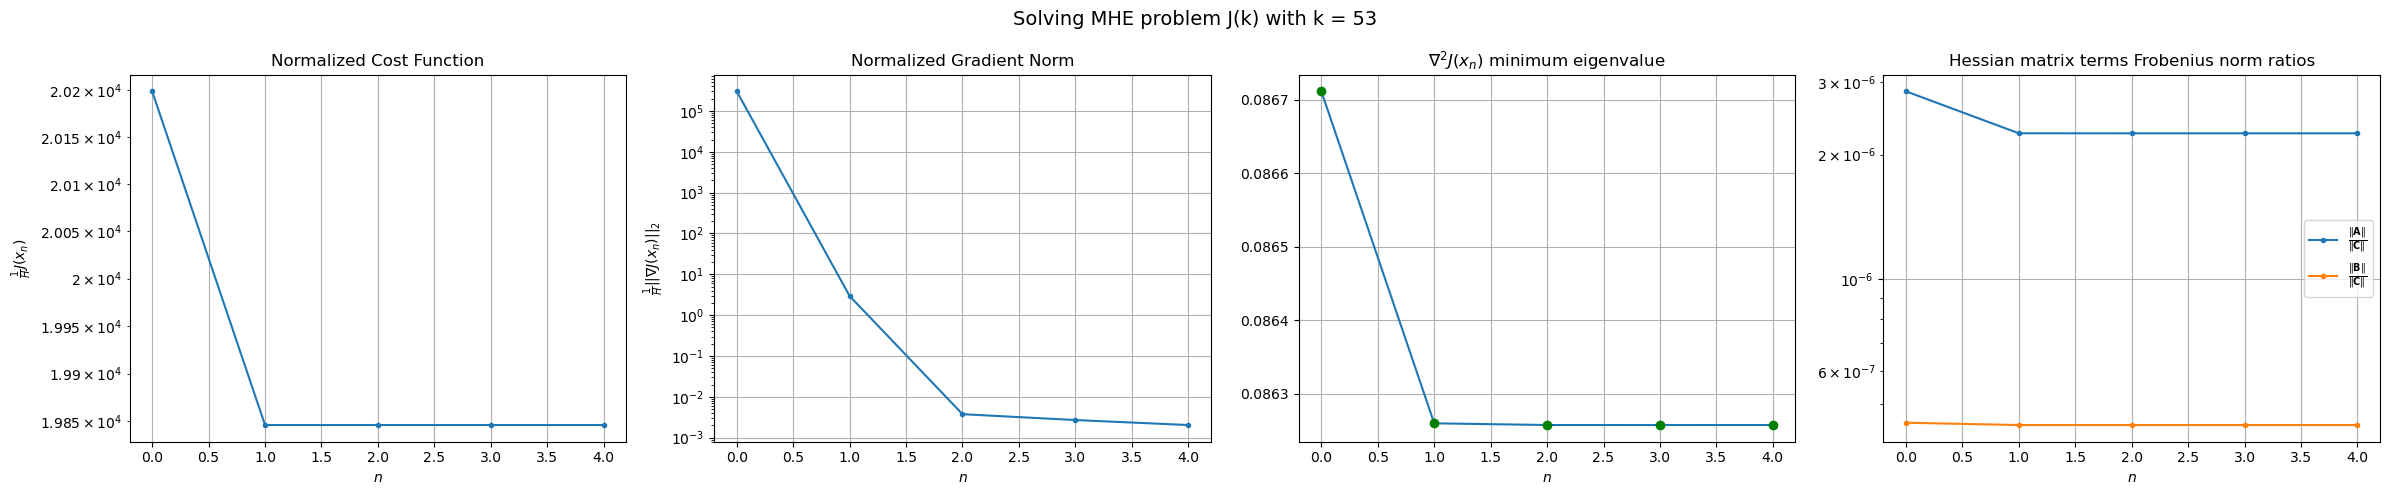

Windows:   1%|▏         | 5/346 [07:49<6:55:23, 73.09s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 924939.2102067822
Gradient norm: 14254274.30817198
Global estimation error: 88.61627121224343
0.061739705136570996 2.283307718765334e-06 4.3521404033431044e-07
Initial conditions estimation errors: 45.622388951964304 m, 44.84676862055291 m, 44.02650615355075 m, 42.68288217188797 m
Position estimation errors: 35.52664115040034 m, 35.80635368910741 m, 37.136470558714656 m, 37.21408069726945 m

[Centralized Newton] Iteration 1
Cost function: 908763.587608835 (-1.75%)
Gradient norm: 268.12579615632865 (-100.00%)
Global estimation error: 92.06214220374775 (3.89%)
0.06279257482906303 1.896443002995056e-06 4.2956854261083205e-07
Initial conditions estimation errors: 49.35488235375011 m, 47.034814127609984 m, 45.65983368441621 m, 41.741953724189266 m
Position estimation errors: 32.006764253644754 m, 33.83475174590156 m, 36.99771627880556 m, 36.60673475283494 m

[Centralized Newton] Iteration 2
Cost function: 908763.5862357318 (-

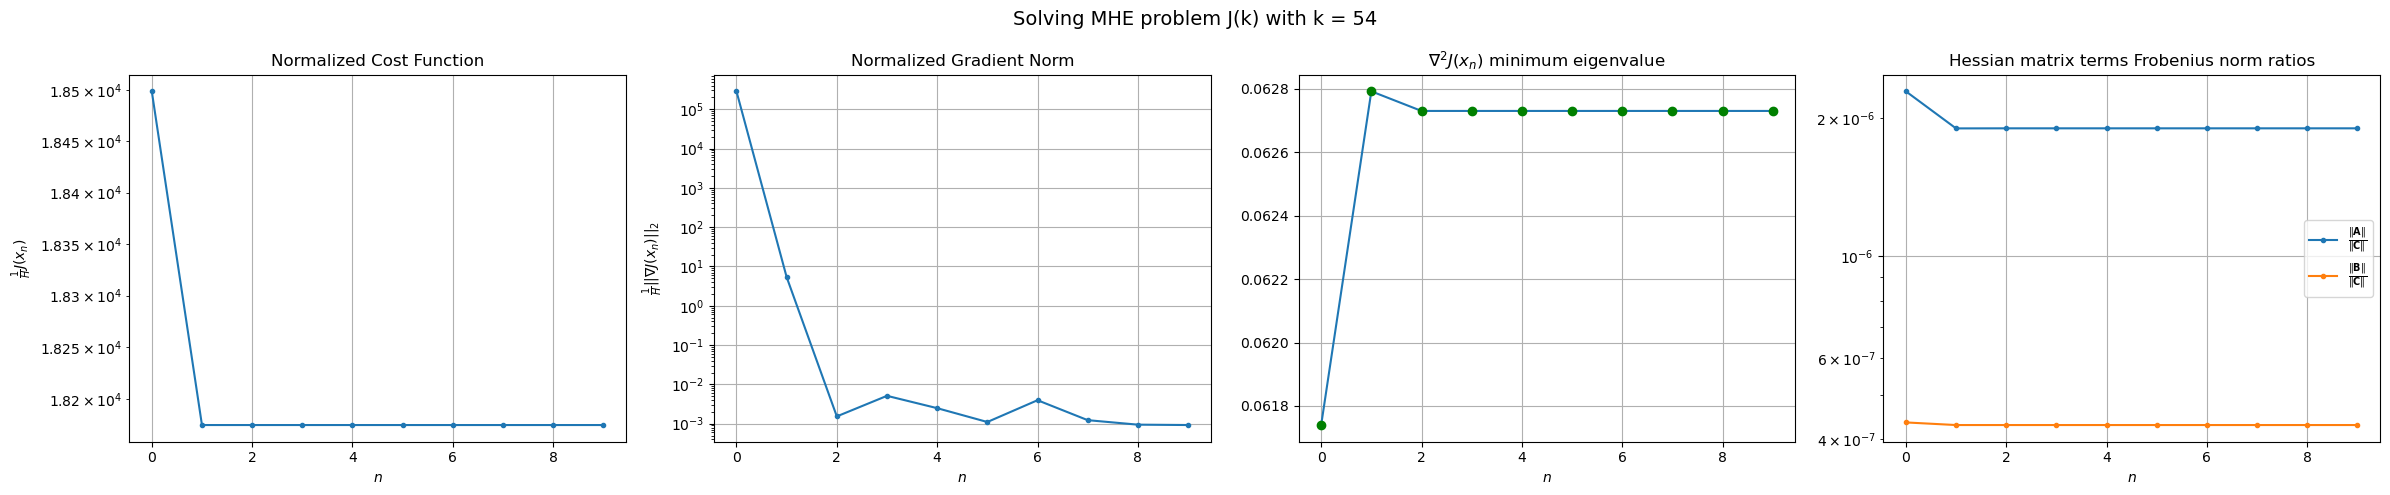

Windows:   2%|▏         | 6/346 [09:42<8:10:38, 86.58s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 847090.2473362316
Gradient norm: 13791359.637941206
Global estimation error: 81.3275379541857
0.04790736112754725 2.2654941649985533e-06 4.2087111801398315e-07
Initial conditions estimation errors: 43.871903408293726 m, 41.80053971473961 m, 39.81068818735899 m, 36.840284439995145 m
Position estimation errors: 34.43828694164364 m, 35.91924791407192 m, 39.54961101851294 m, 39.19296162228311 m

[Centralized Newton] Iteration 1
Cost function: 832159.4552001826 (-1.76%)
Gradient norm: 120.77877214527597 (-100.00%)
Global estimation error: 89.52438478290519 (10.08%)
0.04740656413270019 2.5789904260055942e-06 4.1622156485125335e-07
Initial conditions estimation errors: 47.41160485713452 m, 45.95025884076289 m, 44.20700705434038 m, 41.24349332333162 m
Position estimation errors: 31.01997690628392 m, 32.03030233014013 m, 35.50759573172212 m, 35.18565766307486 m

[Centralized Newton] Iteration 2
Cost function: 832159.4551711142 (-

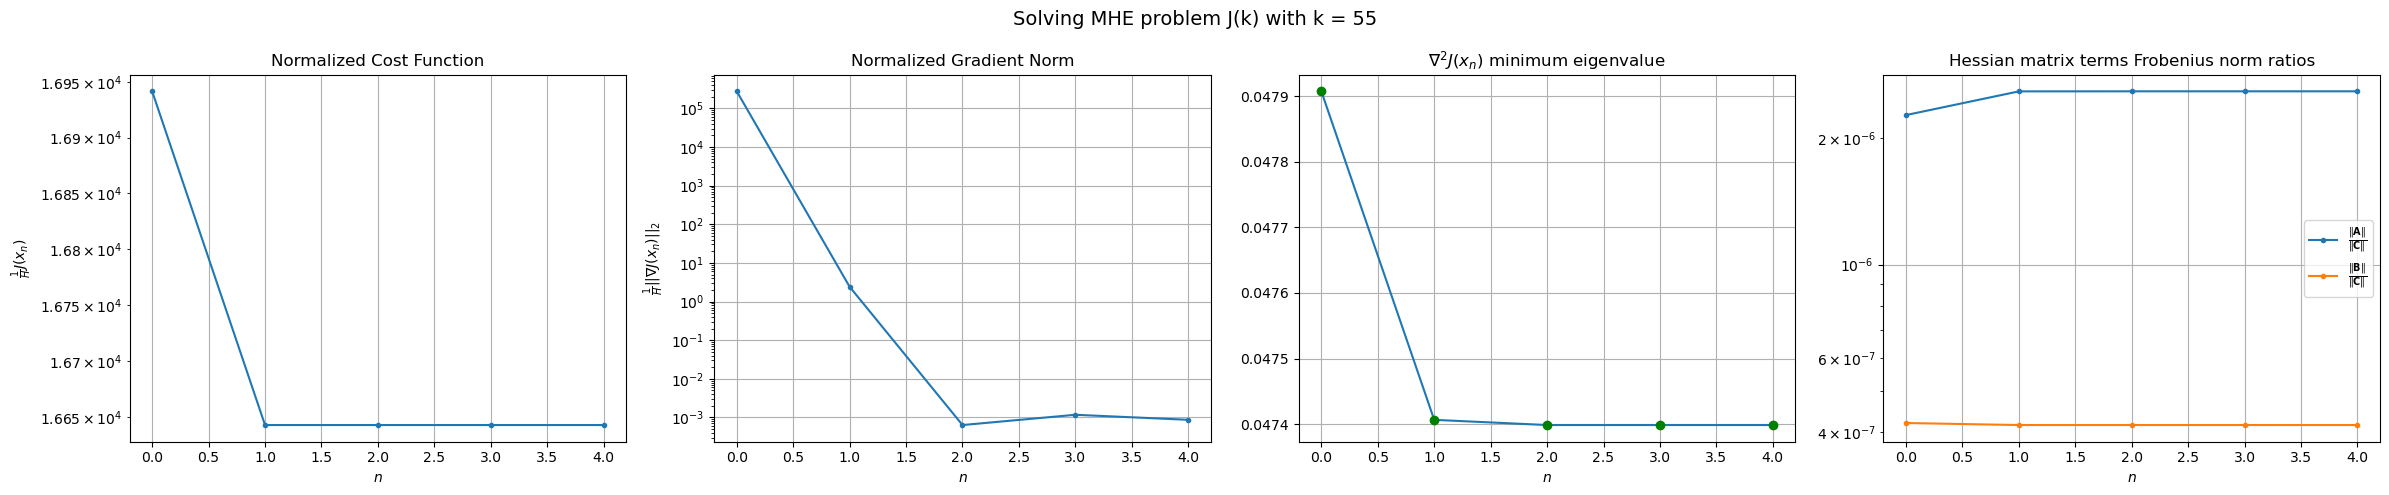

Windows:   2%|▏         | 7/346 [10:39<7:15:28, 77.07s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 775241.728730701
Gradient norm: 13181043.702434193
Global estimation error: 78.86333873569816
0.039035411380621665 2.4067935064295596e-06 4.0786384728826387e-07
Initial conditions estimation errors: 42.03752245645184 m, 40.81540353634579 m, 38.50333987388772 m, 36.10858991701142 m
Position estimation errors: 33.417818221663104 m, 34.118121619568015 m, 38.01761503128588 m, 37.74390072307249 m

[Centralized Newton] Iteration 1
Cost function: 761538.7112313686 (-1.77%)
Gradient norm: 102.5955931800416 (-100.00%)
Global estimation error: 85.18046799241326 (8.01%)
0.038511823238859794 2.844750972594239e-06 4.037366027228137e-07
Initial conditions estimation errors: 45.399256663831515 m, 44.273625304810594 m, 41.34211259563265 m, 39.054526632722066 m
Position estimation errors: 30.122779824308058 m, 30.884324698277677 m, 34.8860542266969 m, 34.653949448488824 m

[Centralized Newton] Iteration 2
Cost function: 761538.7112329263

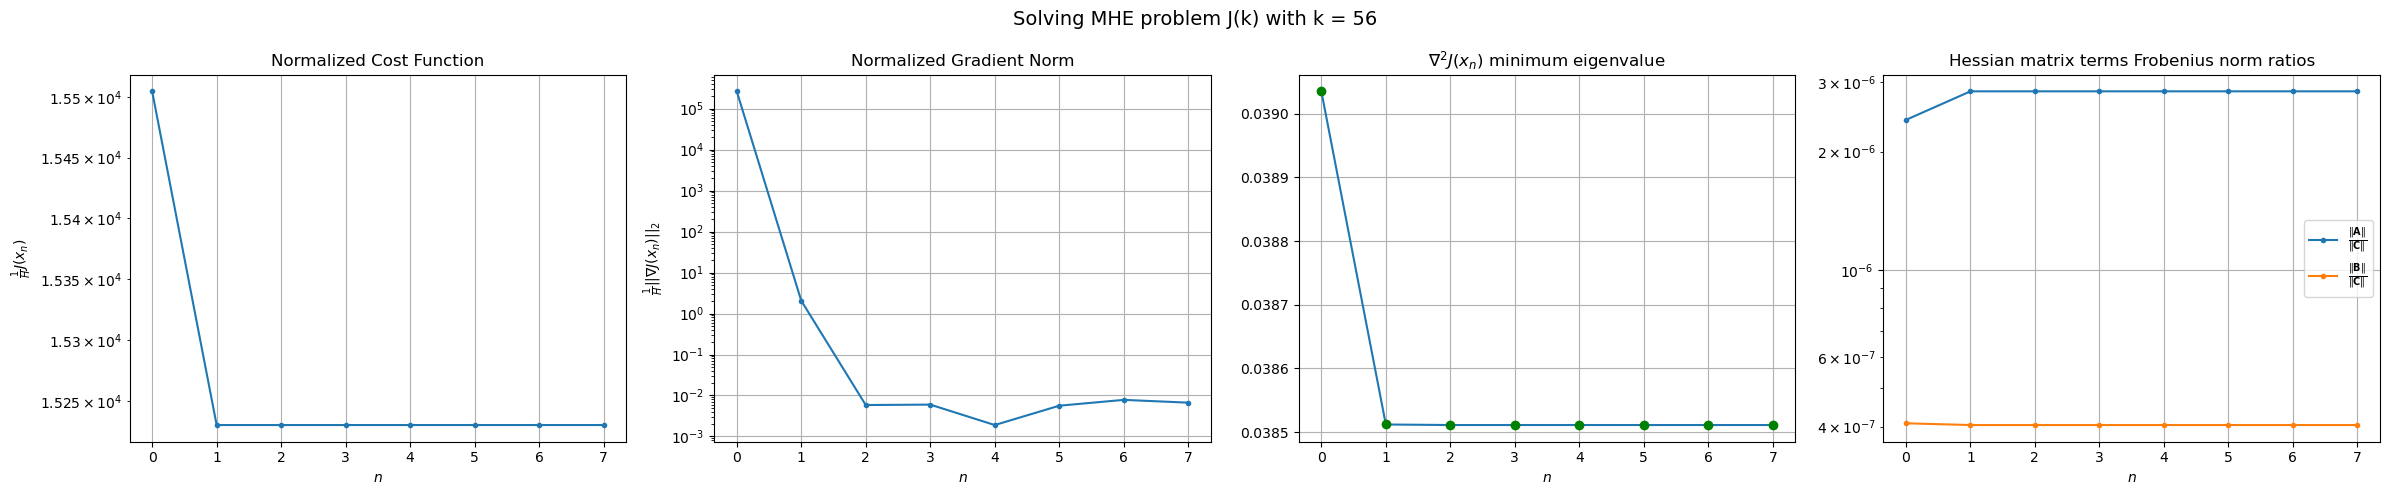

Windows:   2%|▏         | 8/346 [12:09<7:37:38, 81.24s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 711760.3653345384
Gradient norm: 12745959.017250288
Global estimation error: 74.71740495211476
0.034163844956698636 2.2135676484411346e-06 3.9643785682138286e-07
Initial conditions estimation errors: 40.11176227196976 m, 39.245652224538404 m, 35.80585745941433 m, 33.93259199067153 m
Position estimation errors: 32.47954221099091 m, 32.94110127012793 m, 37.382523532211295 m, 37.24274152741915 m

[Centralized Newton] Iteration 1
Cost function: 699142.7953902222 (-1.77%)
Gradient norm: 88.018220080191 (-100.00%)
Global estimation error: 82.40602565141145 (10.29%)
0.0335554493224833 2.249905790328067e-06 3.9292881055133823e-07
Initial conditions estimation errors: 43.312531287502324 m, 42.77583839660644 m, 39.849272439887955 m, 38.691145156507865 m
Position estimation errors: 29.291679829163577 m, 29.466191786667025 m, 32.530671507488876 m, 32.514289191447084 m

[Centralized Newton] Iteration 2
Cost function: 699142.795343550

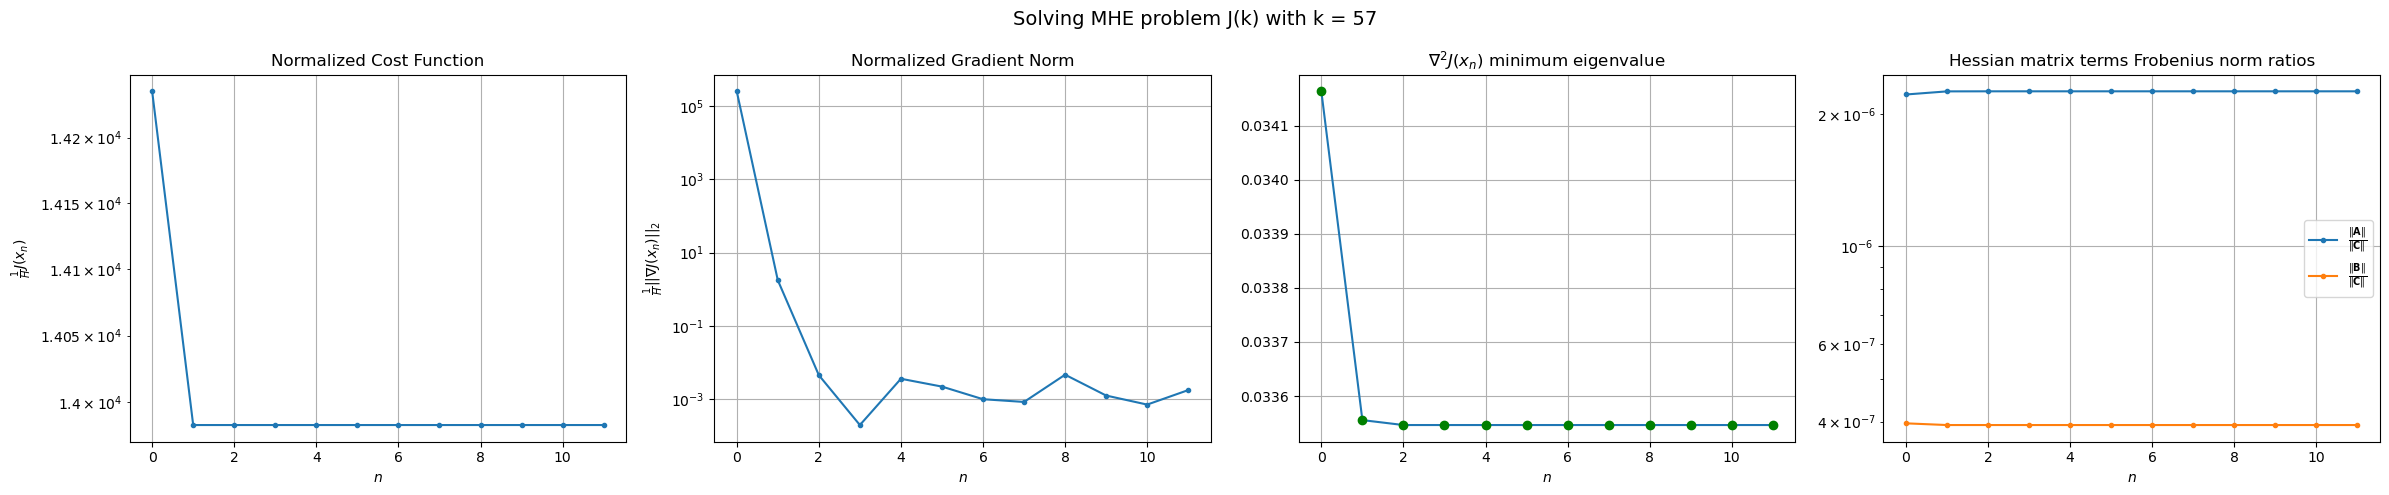

Windows:   3%|▎         | 9/346 [14:23<9:08:33, 97.67s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 654741.8056108027
Gradient norm: 12756695.466180295
Global estimation error: 72.12485753537948
0.030835949833680345 2.522282065517017e-06 3.8511991694430844e-07
Initial conditions estimation errors: 38.08053845997986 m, 37.80705563132178 m, 34.57010846649505 m, 33.576298568603555 m
Position estimation errors: 31.59910852600579 m, 31.493224043134255 m, 34.86365839093603 m, 34.96910185652329 m

[Centralized Newton] Iteration 1
Cost function: 643158.9604854487 (-1.77%)
Gradient norm: 85.15757098297546 (-100.00%)
Global estimation error: 77.93160874543601 (8.05%)
0.031304415552165094 2.4151589983618863e-06 3.836106290023121e-07
Initial conditions estimation errors: 41.122759515536615 m, 40.56034666498482 m, 37.67593158717363 m, 36.29879353102838 m
Position estimation errors: 28.519543793006903 m, 28.691764705390714 m, 31.859802884805443 m, 31.78247177017936 m

[Centralized Newton] Iteration 2
Cost function: 643158.9604758587

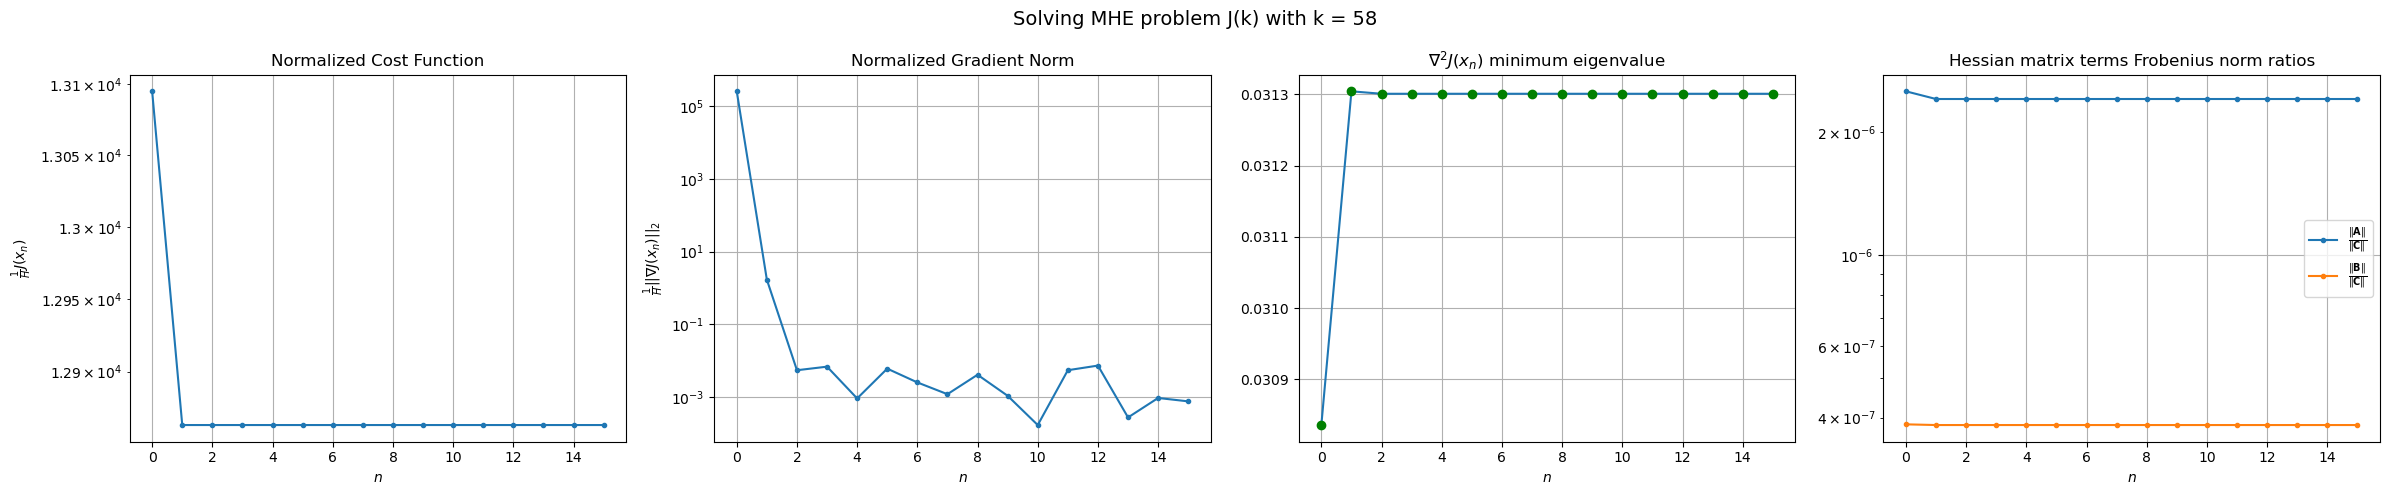

Windows:   3%|▎         | 10/346 [17:21<11:25:42, 122.45s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 605394.0086174237
Gradient norm: 12640543.601481019
Global estimation error: 67.80142011308334
0.030507690497688353 1.8073385117450276e-06 3.7470620178514214e-07
Initial conditions estimation errors: 35.92881936208121 m, 35.635923787882106 m, 32.41926971612379 m, 31.387761189318248 m
Position estimation errors: 30.78333876713614 m, 30.675940645654585 m, 34.10069394004525 m, 34.106091511229394 m

[Centralized Newton] Iteration 1
Cost function: 594774.441646364 (-1.75%)
Gradient norm: 91.80183512196795 (-100.00%)
Global estimation error: 74.84802525419857 (10.39%)
0.03051598790402942 1.723697740682864e-06 3.749904322243965e-07
Initial conditions estimation errors: 38.819977155017135 m, 38.656292673345455 m, 36.418530897037726 m, 35.70133378251148 m
Position estimation errors: 27.813913819668343 m, 27.592694049088767 m, 29.772281387033253 m, 29.69571206611349 m

[Centralized Newton] Iteration 2
Cost function: 594774.4416124

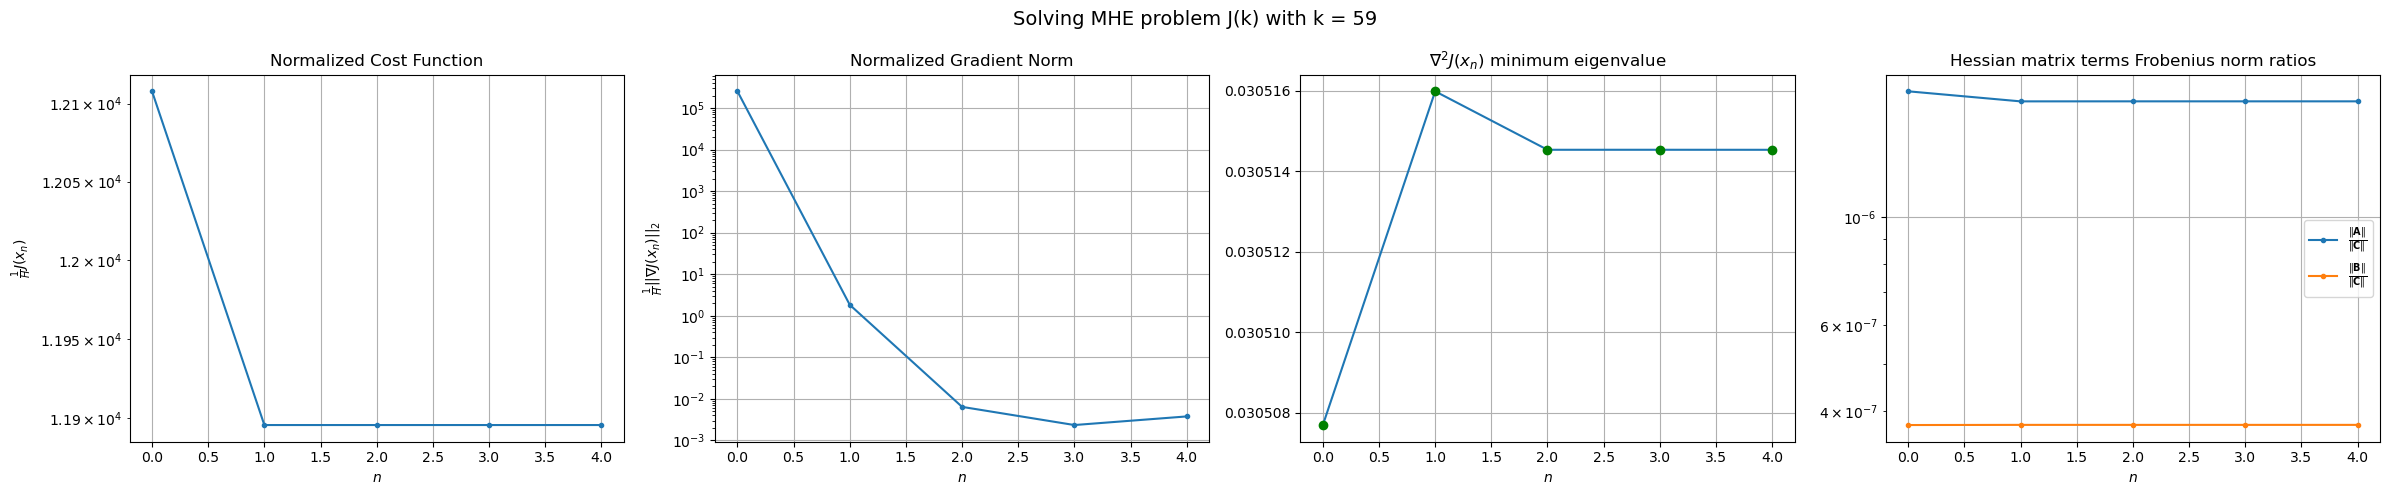

Windows:   3%|▎         | 11/346 [18:19<9:33:28, 102.71s/it] 

[Centralized Newton] Before applying the algorithm
Cost function: 563777.920479434
Gradient norm: 12952165.155797847
Global estimation error: 64.93705222208953
0.03128527312964174 2.252187208497699e-06 3.6478745635220224e-07
Initial conditions estimation errors: 33.691863453037215 m, 33.76518162293111 m, 31.387266952571963 m, 30.92572376107527 m
Position estimation errors: 30.057991471247473 m, 29.601983213753993 m, 31.85862073317767 m, 31.81477522910796 m

[Centralized Newton] Iteration 1
Cost function: 554036.3879360717 (-1.73%)
Gradient norm: 67.46774440472544 (-100.00%)
Global estimation error: 70.77099048831157 (8.98%)
0.031001527125036028 1.401779277870387e-06 3.682415218750702e-07
Initial conditions estimation errors: 36.42659666276946 m, 37.07456011211206 m, 34.25154693153945 m, 33.67362201750447 m
Position estimation errors: 27.17479198157491 m, 26.085125144042053 m, 29.292567904438872 m, 29.409178030317435 m

[Centralized Newton] Iteration 2
Cost function: 554036.3879198437 (

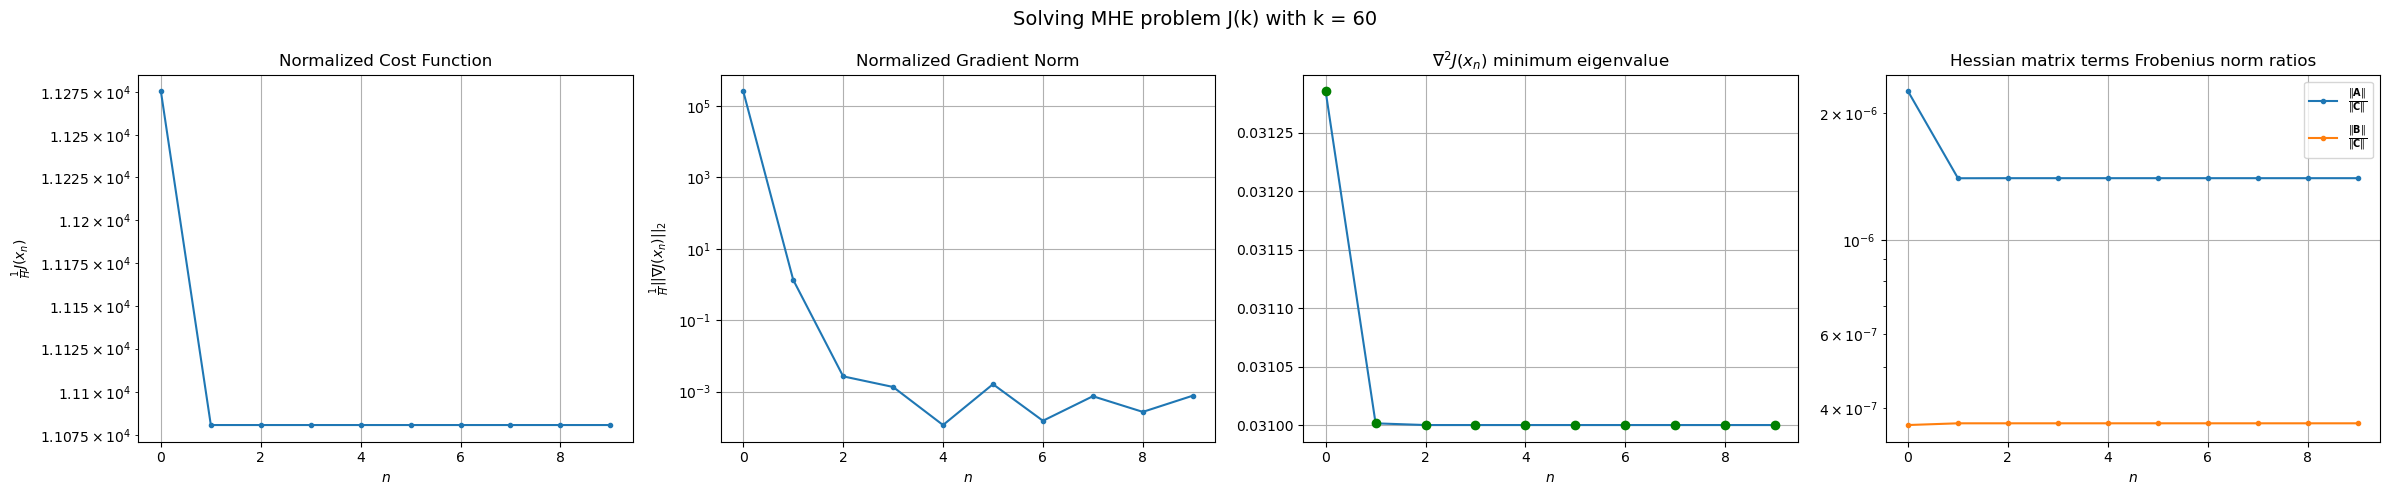

Windows:   3%|▎         | 12/346 [20:11<9:47:53, 105.61s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 530172.6802378368
Gradient norm: 12929034.631792855
Global estimation error: 60.9699515317331
0.031990034655344106 9.714412671218317e-07 3.571452008956554e-07
Initial conditions estimation errors: 31.435806112275003 m, 32.304567651625895 m, 29.232130993309575 m, 28.826960250440507 m
Position estimation errors: 29.425862608595327 m, 28.12030928048663 m, 31.440558923402904 m, 31.668631541684 m

[Centralized Newton] Iteration 1
Cost function: 521270.1267983096 (-1.68%)
Gradient norm: 57.45233483893997 (-100.00%)
Global estimation error: 68.51971476743203 (12.38%)
0.03173202990723945 1.38032456315365e-06 3.630726362843966e-07
Initial conditions estimation errors: 34.02041598794097 m, 34.96177698141882 m, 33.84272090020083 m, 34.20347425436985 m
Position estimation errors: 26.636878730383188 m, 25.446765082915455 m, 27.112429985068943 m, 27.207305863763484 m

[Centralized Newton] Iteration 2
Cost function: 521270.1267657199 (

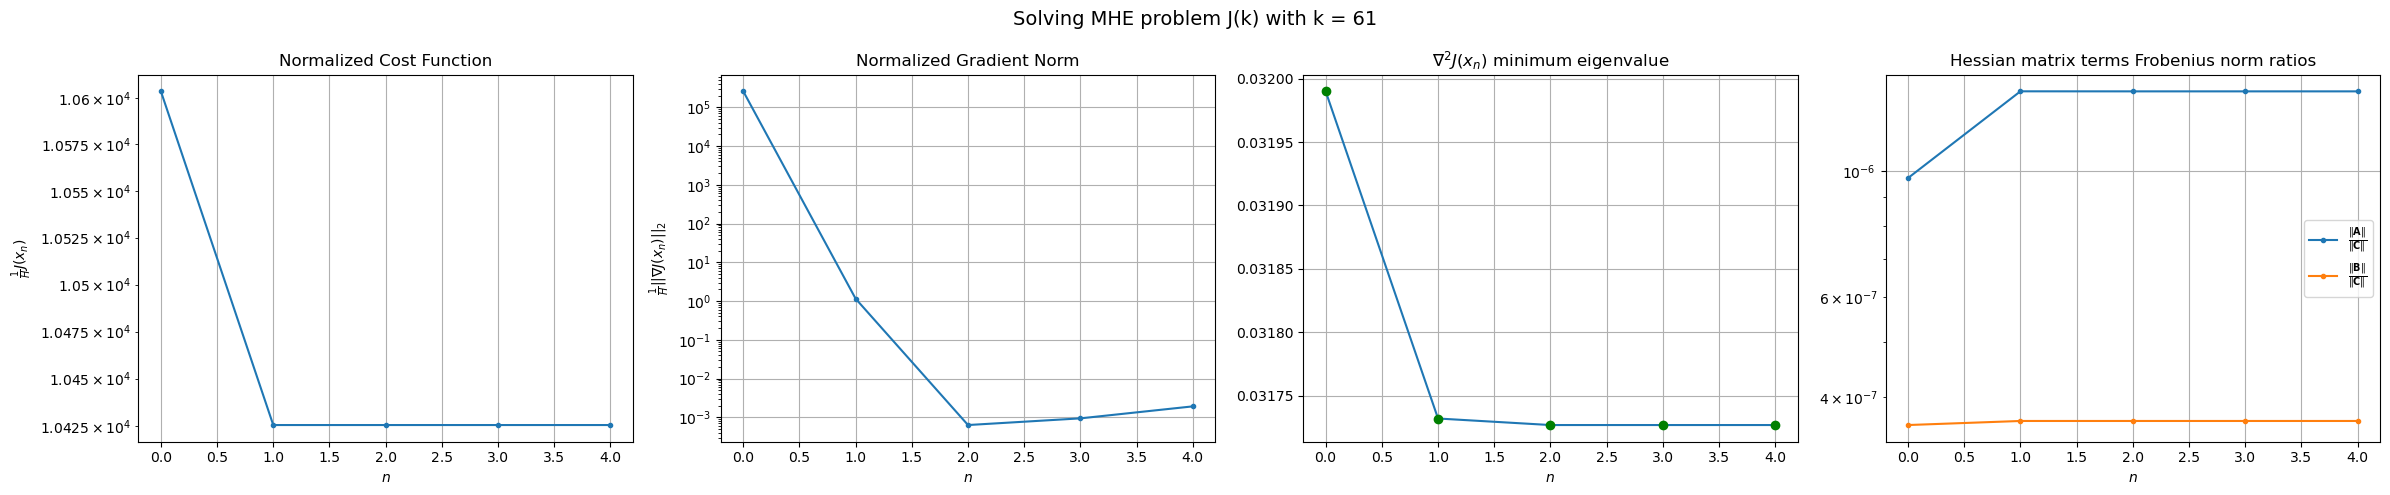

Windows:   4%|▍         | 13/346 [21:09<8:25:54, 91.16s/it] 

[Centralized Newton] Before applying the algorithm
Cost function: 504982.3288911757
Gradient norm: 13148893.038949387
Global estimation error: 59.07602720293817
0.03285526638390981 1.528049742693823e-06 3.5162374689662366e-07
Initial conditions estimation errors: 29.24710750069634 m, 30.344386294510368 m, 29.10220832959025 m, 29.442107184753752 m
Position estimation errors: 28.923916481649982 m, 27.54564590837649 m, 29.356963836861848 m, 29.538762829093322 m

[Centralized Newton] Iteration 1
Cost function: 496843.6660625845 (-1.61%)
Gradient norm: 114.53200652717086 (-100.00%)
Global estimation error: 64.78217675805801 (9.66%)
0.033132481706749234 1.966309146299551e-06 3.598044160360465e-07
Initial conditions estimation errors: 31.687171098817256 m, 32.62127288367089 m, 32.37909864871693 m, 32.86450146256329 m
Position estimation errors: 26.22293951232243 m, 25.278888617279517 m, 25.244468953287537 m, 24.9602614440633 m

[Centralized Newton] Iteration 2
Cost function: 496843.6660378182

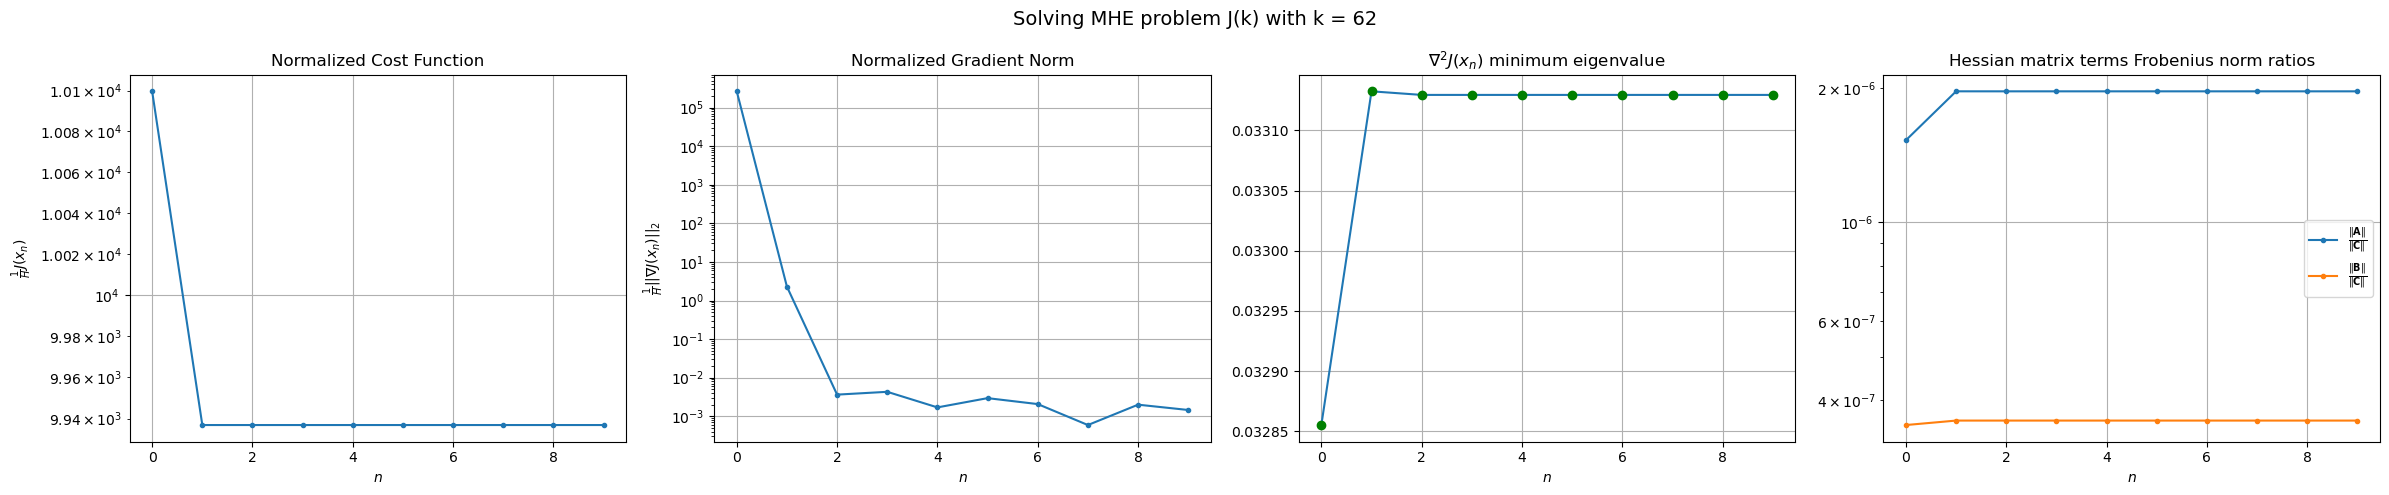

Windows:   4%|▍         | 14/346 [23:02<9:01:06, 97.79s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 487825.8523963471
Gradient norm: 13664550.898979703
Global estimation error: 56.21365996782818
0.03468034938272269 1.6009714094257238e-06 3.475337442704926e-07
Initial conditions estimation errors: 27.199232844117233 m, 28.21947586793467 m, 28.2350753538544 m, 28.750616913858345 m
Position estimation errors: 28.57857610134166 m, 27.496307656467724 m, 27.358662755253505 m, 27.019959647342226 m

[Centralized Newton] Iteration 1
Cost function: 480371.32051860576 (-1.53%)
Gradient norm: 43.902651261540804 (-100.00%)
Global estimation error: 61.38732666182786 (9.20%)
0.03449842509832348 1.902561930424481e-06 3.586664890606745e-07
Initial conditions estimation errors: 29.49890974557598 m, 29.934717209414035 m, 31.092626423659073 m, 32.17699009098829 m
Position estimation errors: 25.954736859008932 m, 25.398715371320687 m, 23.797395259042272 m, 23.390283627911096 m

[Centralized Newton] Iteration 2
Cost function: 480371.3204985

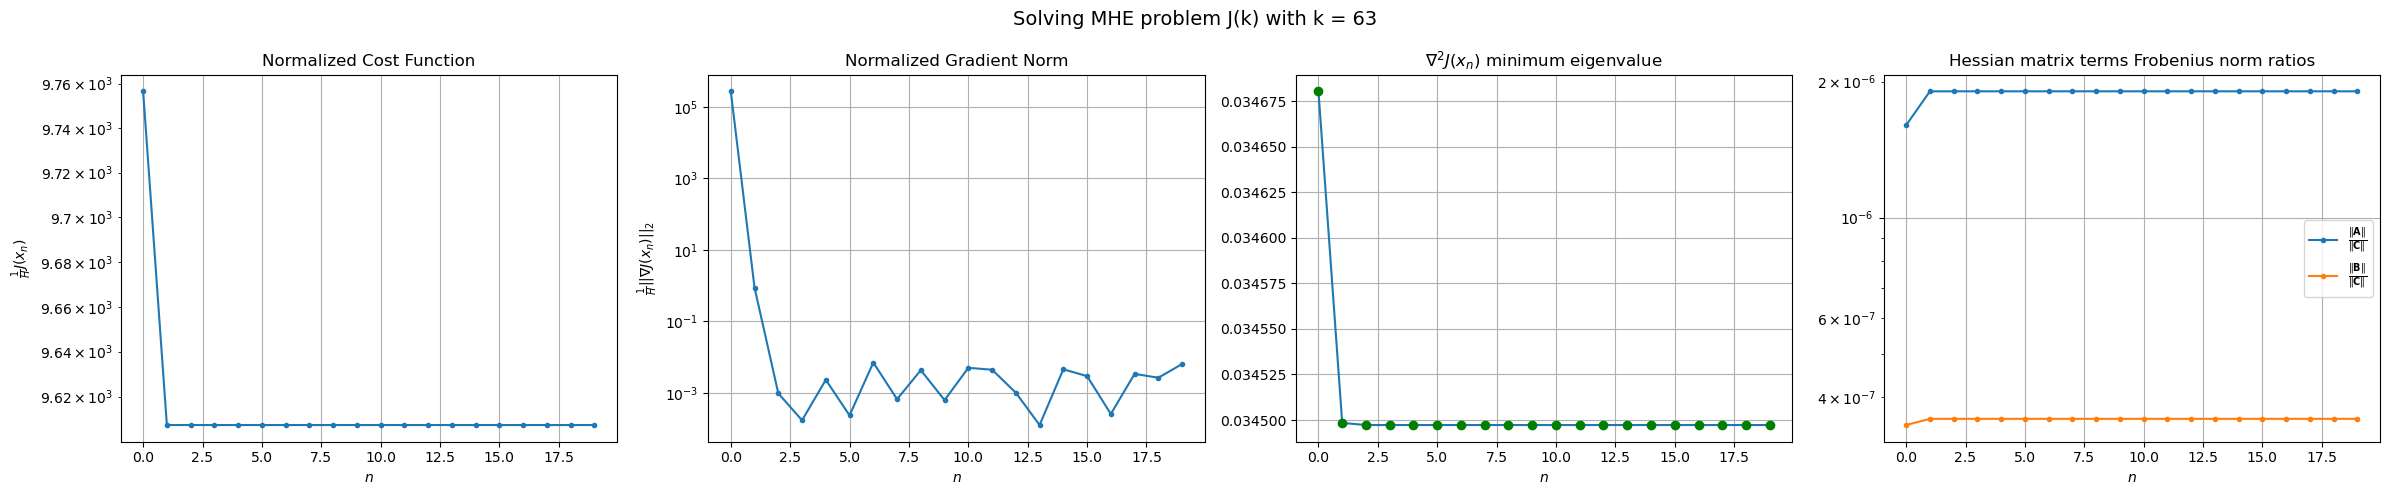

Windows:   4%|▍         | 15/346 [26:46<12:28:59, 135.77s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 477851.22994627367
Gradient norm: 14091013.458013548
Global estimation error: 53.60722815311001
0.03629582319900949 1.8722851625376934e-06 3.4504089726452664e-07
Initial conditions estimation errors: 25.35559516713857 m, 25.924286834809184 m, 27.415329144322406 m, 28.41025458405177 m
Position estimation errors: 28.41883905022992 m, 27.70775763785066 m, 25.967865665900693 m, 25.51649370078418 m

[Centralized Newton] Iteration 1
Cost function: 470942.54394566134 (-1.45%)
Gradient norm: 54.34621088953233 (-100.00%)
Global estimation error: 57.34264041220296 (6.97%)
0.036497841619486694 1.531925549946832e-06 3.58151167723135e-07
Initial conditions estimation errors: 27.536798230869643 m, 28.305677182796817 m, 28.9388948288922 m, 29.853230546185937 m
Position estimation errors: 25.856256407410825 m, 25.018036922074586 m, 23.42009702714458 m, 22.45565368084765 m

[Centralized Newton] Iteration 2
Cost function: 470942.543930169

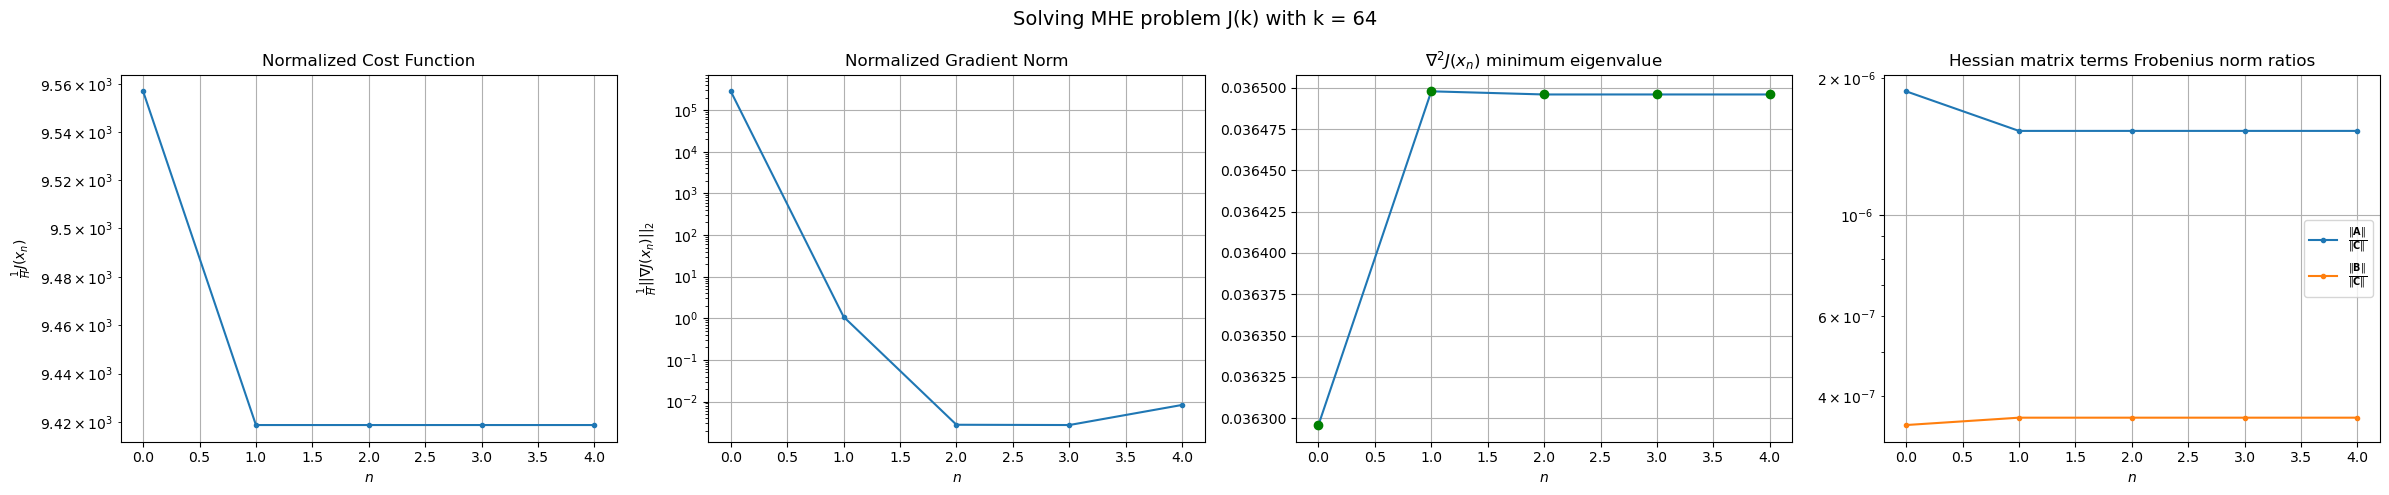

Windows:   5%|▍         | 16/346 [27:43<10:16:40, 112.12s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 473772.85908968066
Gradient norm: 14819503.387712598
Global estimation error: 50.47083881506414
0.03849041774713589 1.638740730959856e-06 3.449095410187691e-07
Initial conditions estimation errors: 23.78090403132088 m, 24.655543739105855 m, 25.753400426602045 m, 26.65759132911823 m
Position estimation errors: 28.48912101606328 m, 27.520922699557094 m, 25.59044256668496 m, 24.44025340546086 m

[Centralized Newton] Iteration 1
Cost function: 467289.45094517217 (-1.37%)
Gradient norm: 30.02001217700369 (-100.00%)
Global estimation error: 53.591690455310165 (6.18%)
0.03853538858667769 8.070511325383389e-07 3.59459733236852e-07
Initial conditions estimation errors: 25.865875609332953 m, 26.013805768065232 m, 27.22672719352566 m, 28.017844977331936 m
Position estimation errors: 25.9718135183124 m, 25.39472140084958 m, 22.97188883628642 m, 22.07661315382315 m

[Centralized Newton] Iteration 2
Cost function: 467289.45093520154 (

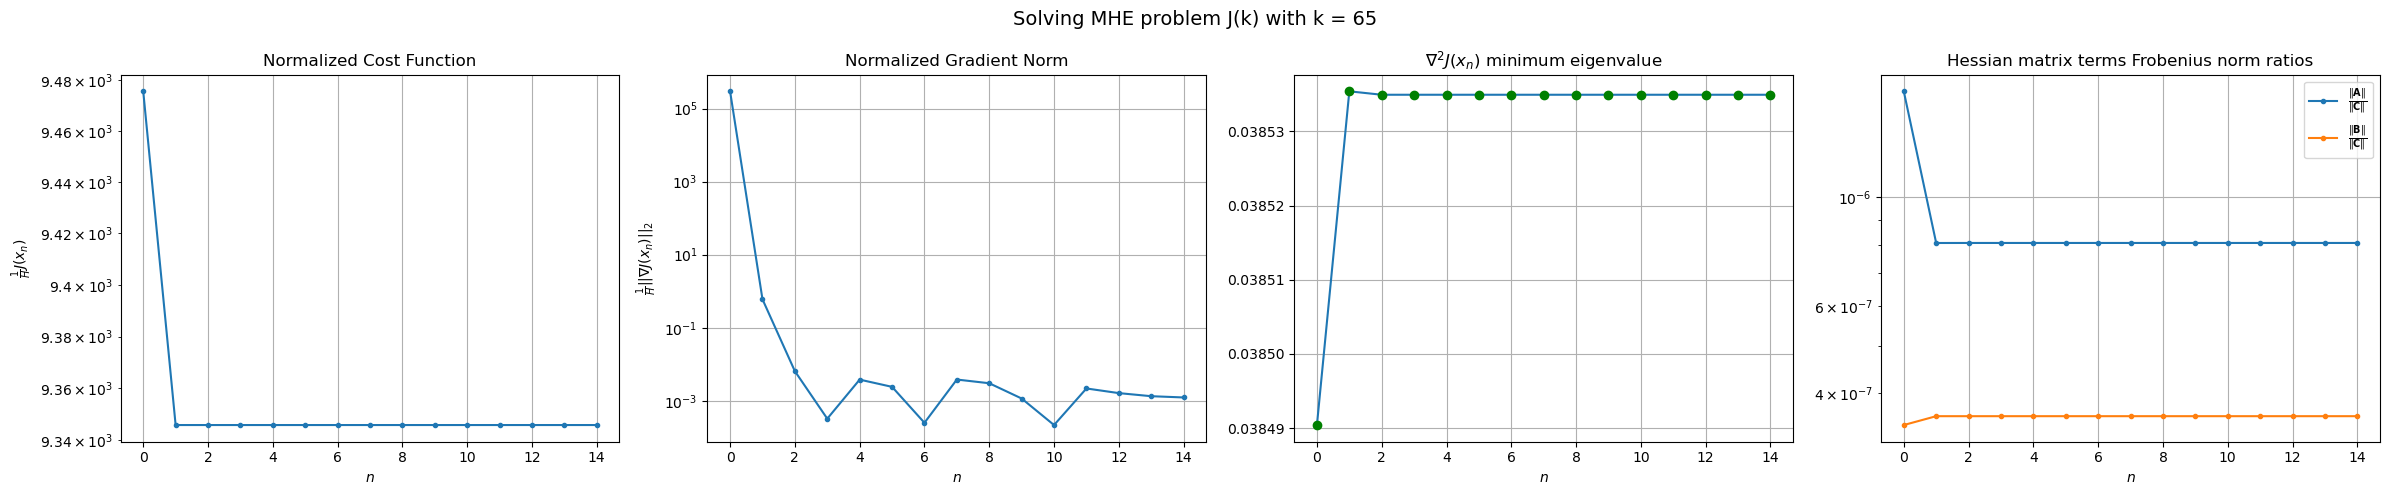

Windows:   5%|▍         | 17/346 [30:29<11:43:48, 128.35s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 475590.64081377845
Gradient norm: 15758003.629463088
Global estimation error: 47.534943366530904
0.040865081834987785 6.981299472910376e-07 3.436828249727219e-07
Initial conditions estimation errors: 22.493280182491965 m, 22.80277465108126 m, 24.440031666213105 m, 25.22559829688258 m
Position estimation errors: 28.85986495185115 m, 28.08311666068536 m, 25.254465969505226 m, 24.135412704235545 m

[Centralized Newton] Iteration 1
Cost function: 469338.1264826959 (-1.31%)
Gradient norm: 62.98988782728458 (-100.00%)
Global estimation error: 50.58183344270793 (6.41%)
0.04122606711968404 6.703756734017242e-07 3.6137260591057475e-07
Initial conditions estimation errors: 24.50159705783966 m, 25.164683729366757 m, 25.45468685274866 m, 26.0188545268103 m
Position estimation errors: 26.336588401066606 m, 25.299032139631624 m, 24.057257960611114 m, 22.421906827426128 m

[Centralized Newton] Iteration 2
Cost function: 469338.12646666

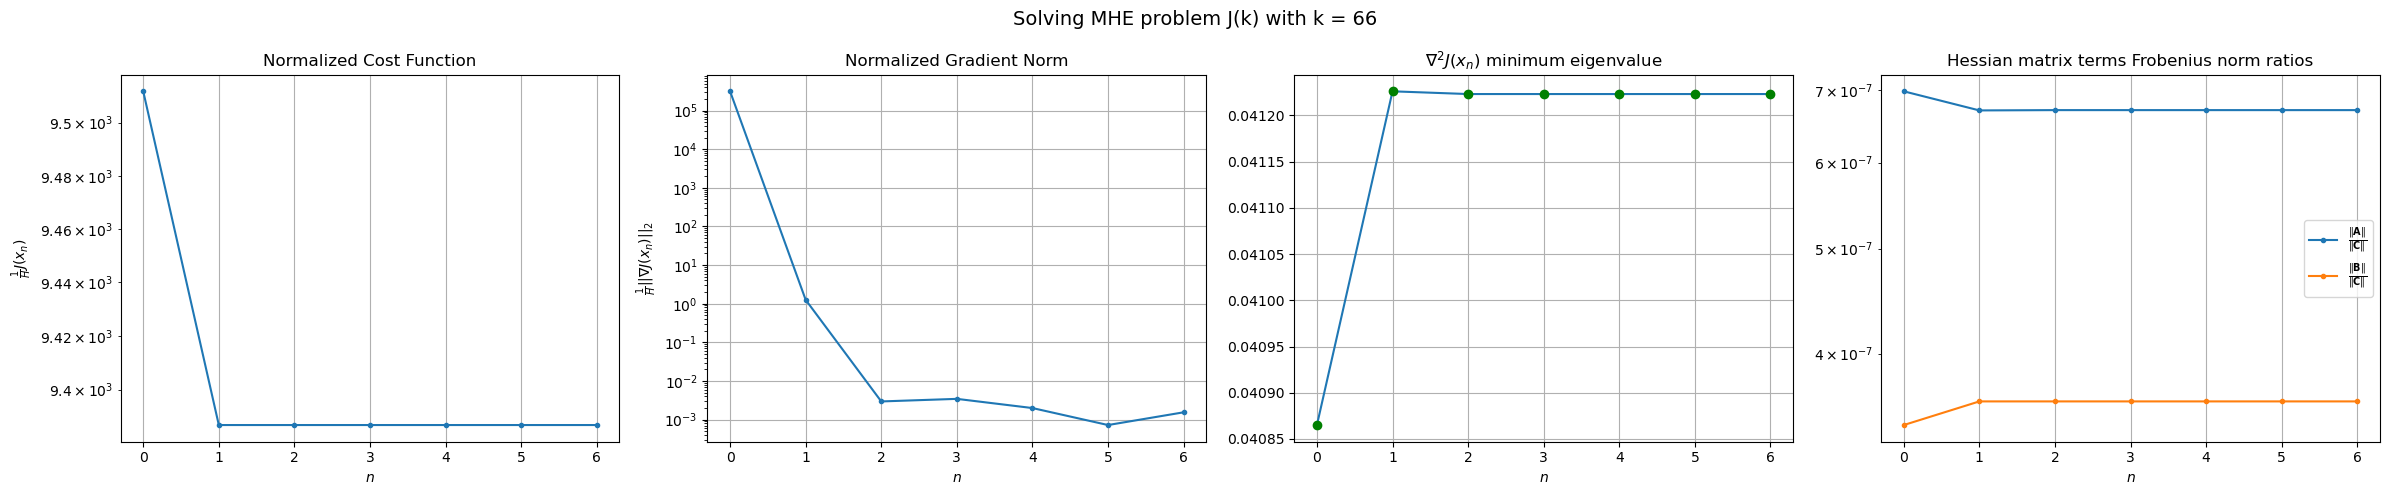

Windows:   5%|▌         | 18/346 [31:49<10:21:41, 113.72s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 483336.1943373505
Gradient norm: 17337533.365175273
Global estimation error: 45.25170043161675
0.04418692047988118 6.967040185690826e-07 3.425194502302575e-07
Initial conditions estimation errors: 21.467560419059385 m, 22.24648382558147 m, 23.065333989486778 m, 23.66296983413802 m
Position estimation errors: 29.574315687015915 m, 28.3870901842501 m, 26.705701332644885 m, 24.558140368246868 m

[Centralized Newton] Iteration 1
Cost function: 477036.20854091557 (-1.30%)
Gradient norm: 32.15724406219799 (-100.00%)
Global estimation error: 47.12204146097334 (4.13%)
0.04415237057106415 7.782824576439602e-07 3.6438185757585296e-07
Initial conditions estimation errors: 23.433143079040214 m, 23.31513283204051 m, 23.620740349035472 m, 23.871141458632703 m
Position estimation errors: 26.976545228974373 m, 26.557882361953737 m, 25.52987657969527 m, 23.69933970248964 m

[Centralized Newton] Iteration 2
Cost function: 477036.208521786

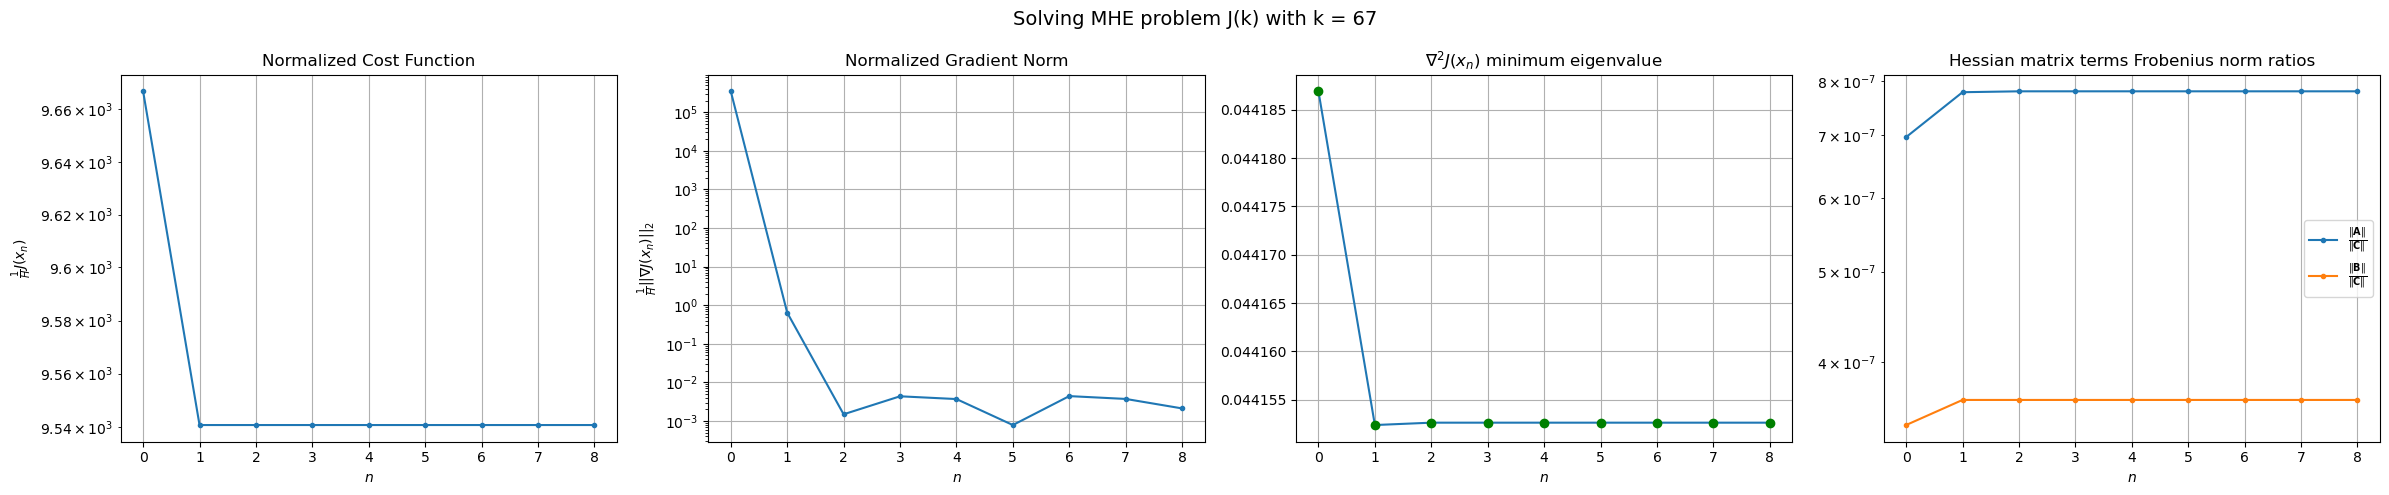

Windows:   5%|▌         | 19/346 [33:31<10:01:01, 110.28s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 496622.4240712743
Gradient norm: 18745877.53166288
Global estimation error: 42.33856949725043
0.04764505484829129 8.250194934660739e-07 3.423605972694705e-07
Initial conditions estimation errors: 20.69602824125047 m, 20.7772258521898 m, 21.464024421669585 m, 21.721523072197265 m
Position estimation errors: 30.629925126819295 m, 29.97850635448166 m, 28.636674837826774 m, 26.224947607751535 m

[Centralized Newton] Iteration 1
Cost function: 490154.3833922025 (-1.30%)
Gradient norm: 27.391240215004434 (-100.00%)
Global estimation error: 45.411429370980464 (7.26%)
0.04767151709200853 5.465949065625489e-07 3.6793393841724994e-07
Initial conditions estimation errors: 22.645294229988806 m, 23.04264838511079 m, 22.70340127950364 m, 22.42706809579625 m
Position estimation errors: 27.93382585241626 m, 26.940213014271826 m, 27.01098811468846 m, 25.14492551994376 m

[Centralized Newton] Iteration 2
Cost function: 490154.3833845212 (

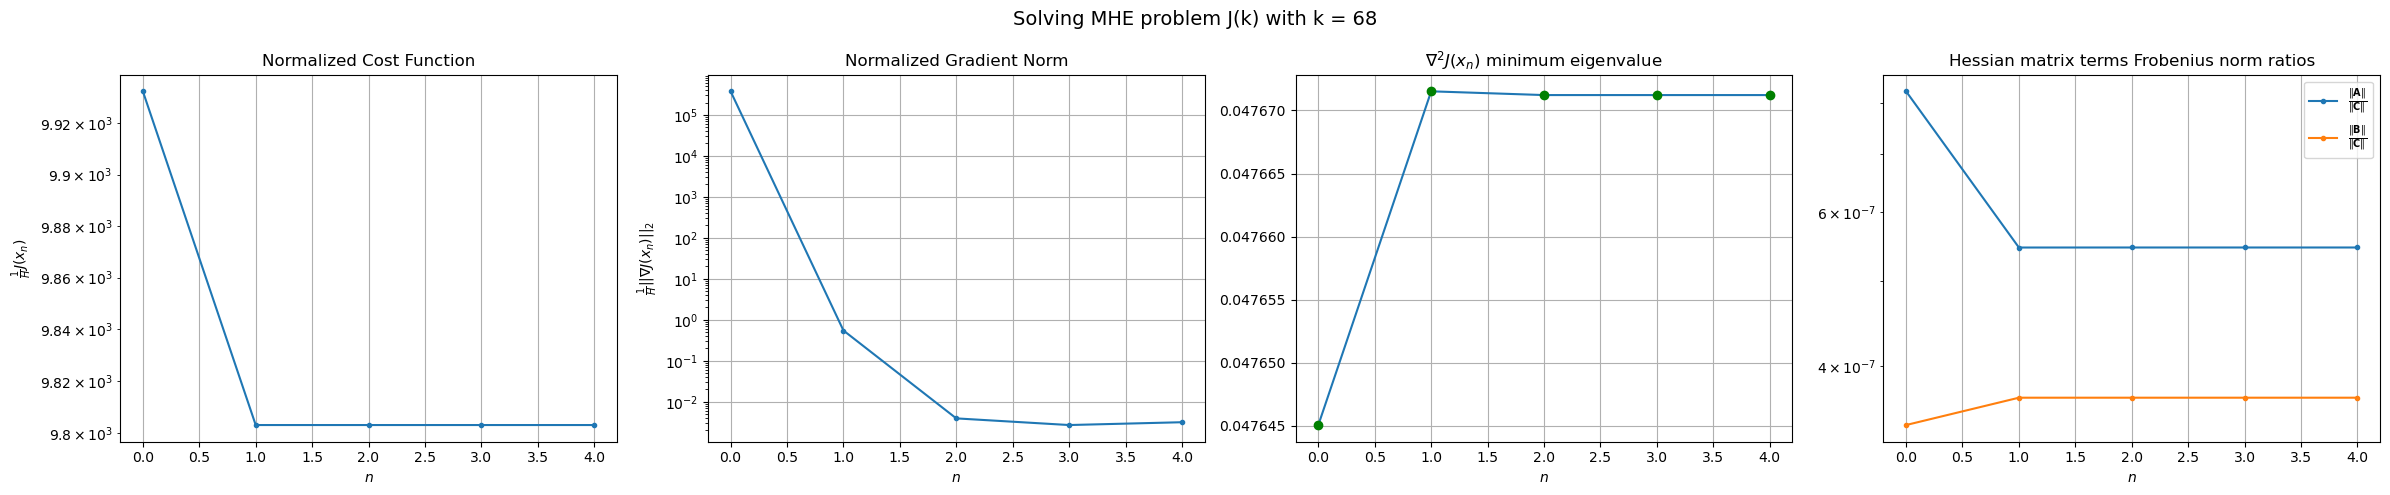

Windows:   6%|▌         | 20/346 [34:29<8:32:58, 94.41s/it]  

[Centralized Newton] Before applying the algorithm
Cost function: 515894.58852030075
Gradient norm: 20153830.23711341
Global estimation error: 41.06081650249338
0.05172057474912092 8.056557534753007e-07 3.404675226928852e-07
Initial conditions estimation errors: 20.190951493581036 m, 20.76673570997959 m, 20.719365716092724 m, 20.43919826083516 m
Position estimation errors: 32.020096702654804 m, 30.804385004973472 m, 30.65900286643312 m, 28.243347559320732 m

[Centralized Newton] Iteration 1
Cost function: 509176.2265107885 (-1.30%)
Gradient norm: 29.80080222094459 (-100.00%)
Global estimation error: 44.37826068543678 (8.08%)
0.051686611464456404 6.025449762878907e-07 3.6979406242847087e-07
Initial conditions estimation errors: 22.13738804250437 m, 22.652146765829453 m, 22.24480885578818 m, 21.711950480971755 m
Position estimation errors: 29.206324098362785 m, 28.156230986079464 m, 27.6641050594567 m, 26.048736907743184 m

[Centralized Newton] Iteration 2
Cost function: 509176.226507912

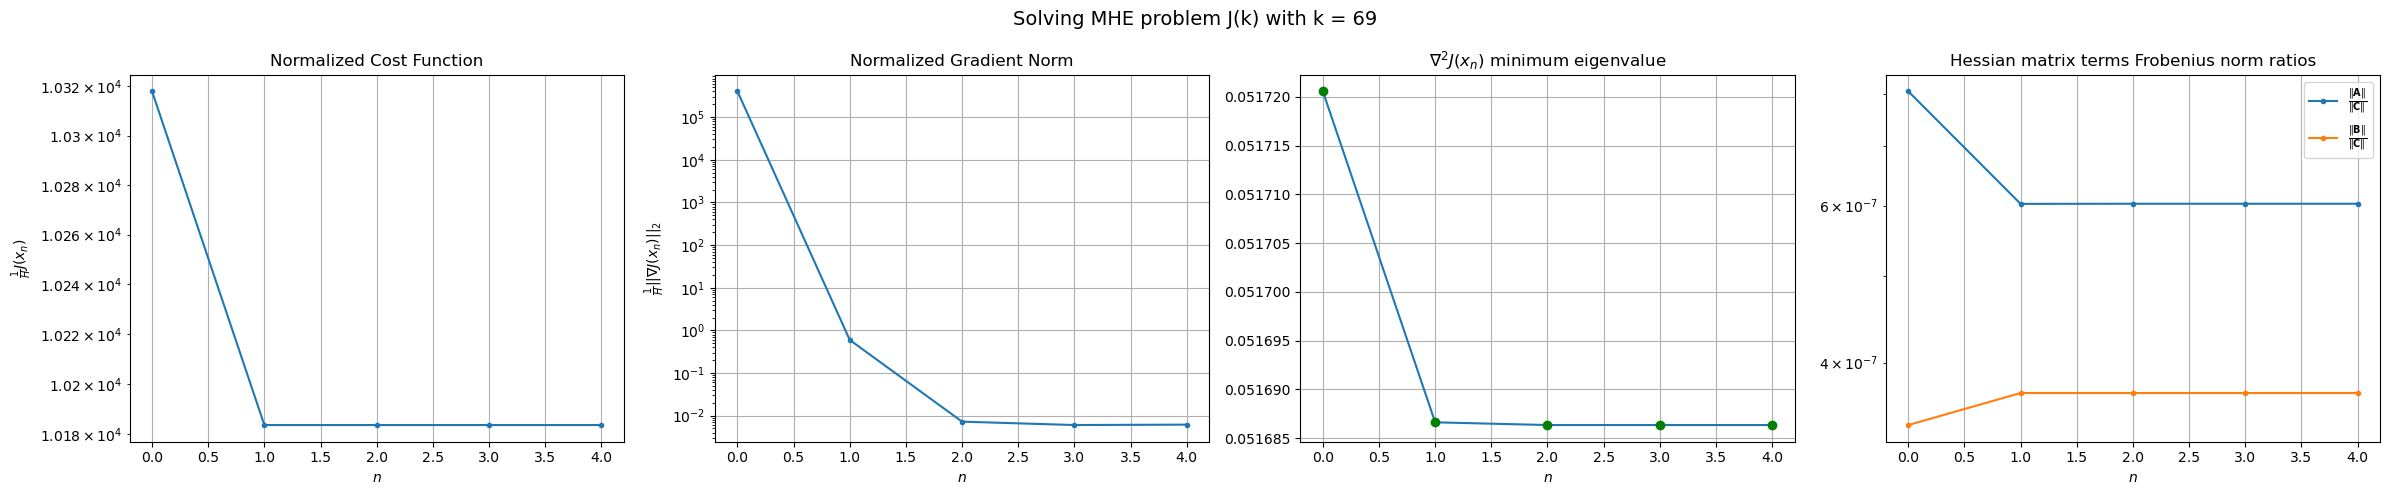

Windows:   6%|▌         | 21/346 [35:26<7:31:09, 83.29s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 541898.9759729543
Gradient norm: 21764664.576762177
Global estimation error: 40.47509094613063
0.05654930028979728 6.810337559149789e-07 3.389055056657914e-07
Initial conditions estimation errors: 19.949445836199644 m, 20.680725499039514 m, 20.420594665554795 m, 19.888545868051867 m
Position estimation errors: 33.69979382819697 m, 32.42004903843226 m, 31.697130109584762 m, 29.570874107341556 m

[Centralized Newton] Iteration 1
Cost function: 534643.5971193578 (-1.34%)
Gradient norm: 67.28446503058817 (-100.00%)
Global estimation error: 45.189904456911464 (11.65%)
0.05616837583220405 3.9433694664628567e-07 3.70733059294673e-07
Initial conditions estimation errors: 21.949570368382464 m, 22.88530528798143 m, 22.737028225064304 m, 22.795360778139976 m
Position estimation errors: 30.71891102196973 m, 28.713030029269888 m, 28.329338595814097 m, 26.638612949106808 m

[Centralized Newton] Iteration 2
Cost function: 534643.597097

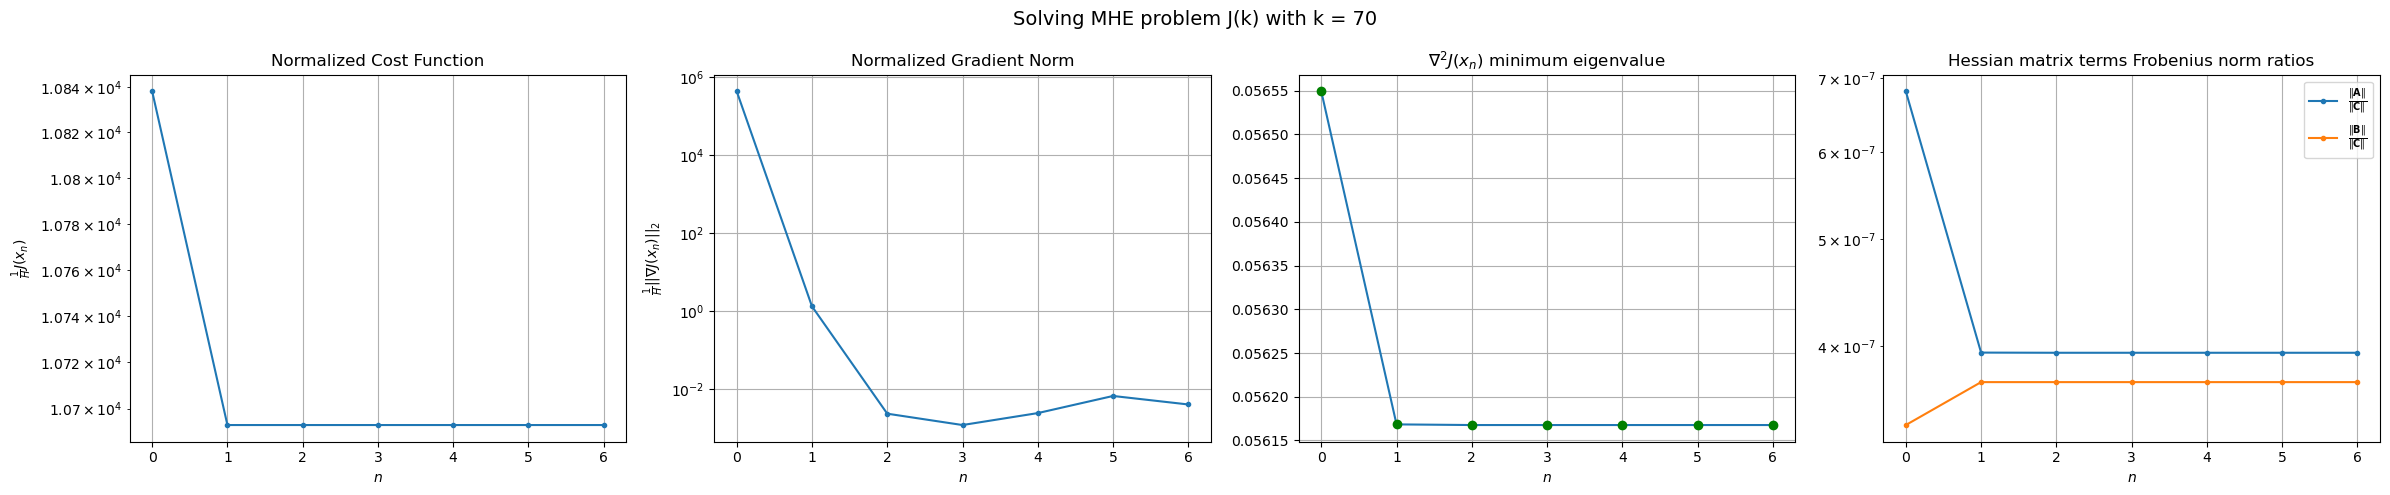

Windows:   6%|▋         | 22/346 [36:45<7:23:17, 82.09s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 574185.6388351558
Gradient norm: 23008310.05594768
Global estimation error: 41.48415525991324
0.06096741249263564 4.956180200204676e-07 3.361359912758331e-07
Initial conditions estimation errors: 19.982033649526787 m, 21.084561972592557 m, 20.92221536779511 m, 20.960678030771813 m
Position estimation errors: 35.582984441686975 m, 33.333358816413444 m, 32.876989169525956 m, 30.89518977133104 m

[Centralized Newton] Iteration 1
Cost function: 566335.7597640314 (-1.37%)
Gradient norm: 36.18901921694967 (-100.00%)
Global estimation error: 45.57849007117032 (9.87%)
0.060841710168153915 5.259234821226086e-07 3.687245467171331e-07
Initial conditions estimation errors: 22.05870559062014 m, 23.976211036367076 m, 22.78076325108636 m, 22.293149517382147 m
Position estimation errors: 32.436981076290394 m, 29.943765455366968 m, 31.878381593552945 m, 30.168373556383937 m

[Centralized Newton] Iteration 2
Cost function: 566335.75976532

KeyboardInterrupt: 

In [7]:
first_round_stop_iteration = []
K_minus_H_next_rounds_stop_iteration = []

# Cold-start
x_init = X_initial + np.random.multivariate_normal(np.zeros(n), P_0).reshape((n, 1))

# Apply the algorithm
X_est = np.zeros((n, 1, K))
for k in tqdm(range(H - 1, K), desc="Windows", leave=False):
    centralized_newton.cost_values, centralized_newton.gradient_norm_values, centralized_newton.HJ_x_eigenvalues_history, centralized_newton.A_norm_history, centralized_newton.B_norm_history, centralized_newton.C_norm_history = [], [], [], [], [], []
    x_init, x_est = centralized_newton.solve_MHE_problem_with_metrics(k, dt, Y, x_init, X_true[:, :, k - H + 1],  X_true[:, :, k])
    X_est[:, :, k] = x_est
    
    plots(k, centralized_newton)

    # Warm-start
    x_init = dyn.f(dt, x_init)

# After each Monte Carlo Run compute the RMSE_m for each K - H + 1 timestamps
position_estimation_error_1, position_estimation_error_2, position_estimation_error_3, position_estimation_error_4 = [], [], [], []
for k in range(H - 1, K):
    position_estimation_error_1.append(np.linalg.norm(X_est[:n_p, :, k] - X_true[:n_p, :, k]))
    position_estimation_error_2.append(np.linalg.norm(X_est[n_x:n_x + n_p, :, k] - X_true[n_x:n_x + n_p, :, k]))
    position_estimation_error_3.append(np.linalg.norm(X_est[2*n_x:2*n_x + n_p, :, k] - X_true[2*n_x:2*n_x + n_p, :, k]))
    position_estimation_error_4.append(np.linalg.norm(X_est[3*n_x:3*n_x + n_p, :, k] - X_true[3*n_x:3*n_x + n_p, :, k]))
rmse_1 = np.sqrt(np.mean(np.array(position_estimation_error_1) ** 2))
rmse_2 = np.sqrt(np.mean(np.array(position_estimation_error_2) ** 2))
rmse_3 = np.sqrt(np.mean(np.array(position_estimation_error_3) ** 2))
rmse_4 = np.sqrt(np.mean(np.array(position_estimation_error_4) ** 2))
print(f'This Monte Carlo run RMSE for {K - H + 1} timestamps:')
print(f'RMSE_1 = {np.mean(rmse_1)}\nRMSE_2 = {np.mean(rmse_2)}\nRMSE_3 = {np.mean(rmse_3)}\nRMSE_4 = {np.mean(rmse_4)}')
print(f'CentralizedNewton applied to J(H - 1) converged with {first_round_stop_iteration} iterations.')
print(f'CentralizedNewton applied to J(k) with k = H, ..., K - 1 converged with {np.mean(K_minus_H_next_rounds_stop_iteration)} iterations on average.')

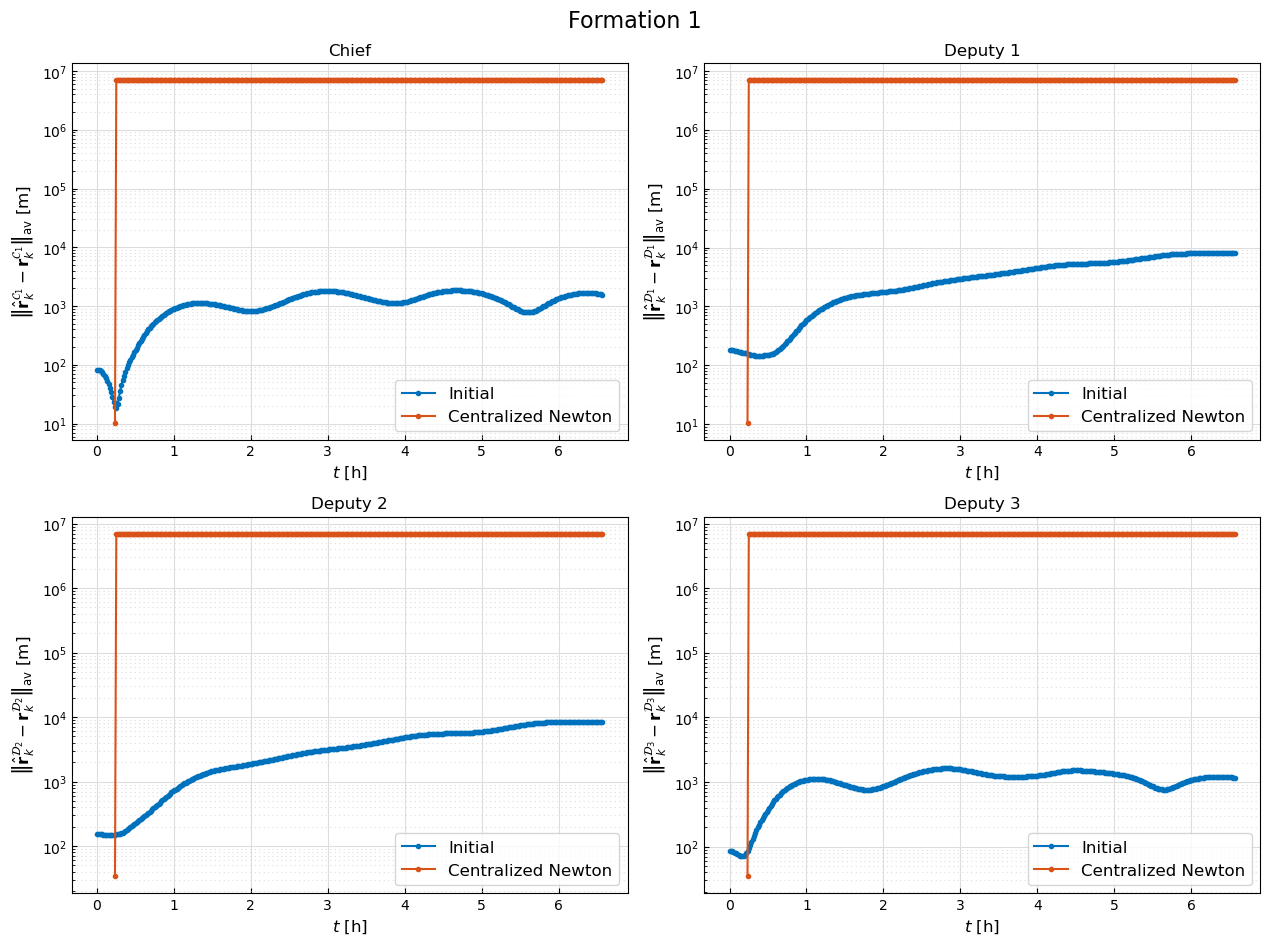

In [ ]:
# MATLAB default color cycle
matlab_default_colors = [
    [0, 0.4470, 0.7410],  # blue
    [0.8500, 0.3250, 0.0980],  # orange
    [0.9290, 0.6940, 0.1250],  # yellow
    [0.4940, 0.1840, 0.5560],  # purple
    [0.4660, 0.6740, 0.1880],  # green
    [0.3010, 0.7450, 0.9330],  # light blue
    [0.6350, 0.0780, 0.1840],  # red
]
# Set the color cycle in Matplotlib to match MATLAB's default
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=matlab_default_colors)

time = np.arange(0, K) / dt
algorithm = "Centralized Newton"

# Plot positions based on screen size
fig_width = 2 * 6.4  # in inchesa
fig_height = 2 * 4.8  # in inches

# Create a 2 by 2 figure
fig, axs = plt.subplots(2, 2, figsize=(fig_width, fig_height))

# Plot 1: Chief
axs[0, 0].plot(time, position_estimation_error_1_initial, ".-", label="Initial")
axs[0, 0].plot(time[H - 1:], position_estimation_error_1, ".-", label=algorithm)
axs[0, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 0].grid(True, which="both")
axs[0, 0].set_yscale("log")
axs[0, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{C}_1} - \\mathbf{r}_k^{\\mathcal{C}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[0, 0].set_ylim([1e-2, 1e3])
axs[0, 0].tick_params(axis="both", which="both", direction="in")
axs[0, 0].legend(fontsize=12)
axs[0, 0].set_title("Chief")

# Plot 2: Deputy 1
axs[0, 1].plot(time, position_estimation_error_2_initial, ".-", label="Initial")
axs[0, 1].plot(time[H - 1:], position_estimation_error_2, ".-", label=algorithm)
axs[0, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 1].grid(True, which="both")
axs[0, 1].set_yscale("log")
axs[0, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_1} - \\mathbf{r}_k^{\\mathcal{D}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[0, 1].set_ylim([1e-1, 1e3])
axs[0, 1].tick_params(axis="both", which="both", direction="in")
axs[0, 1].legend(fontsize=12)
axs[0, 1].set_title("Deputy 1")

# Plot 3: Deputy 2
axs[1, 0].plot(time, position_estimation_error_3_initial, ".-", label="Initial")
axs[1, 0].plot(time[H - 1:], position_estimation_error_3, ".-", label=algorithm)
axs[1, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 0].grid(True, which="both")
axs[1, 0].set_yscale("log")
axs[1, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_2} - \\mathbf{r}_k^{\\mathcal{D}_2}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[1, 0].set_ylim([1e-1, 1e3])
axs[1, 0].tick_params(axis="both", which="both", direction="in")
axs[1, 0].legend(fontsize=12)
axs[1, 0].set_title("Deputy 2")

# Plot 4: Deputy 3
axs[1, 1].plot(time, position_estimation_error_4_initial, ".-", label="Initial")
axs[1, 1].plot(time[H - 1:], position_estimation_error_4, ".-", label=algorithm)
axs[1, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 1].grid(True, which="both")
axs[1, 1].set_yscale("log")
axs[1, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_3} - \\mathbf{r}_k^{\\mathcal{D}_3}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[1, 1].set_ylim([1e-1, 1e3])
axs[1, 1].tick_params(axis="both", which="both", direction="in")
axs[1, 1].legend(fontsize=12)
axs[1, 1].set_title("Deputy 3")

fig.suptitle(f"Formation {formation}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()